# Notebook Instructions

1. If you are new to Jupyter notebooks, please go through this introductory manual <a href='https://quantra.quantinsti.com/quantra-notebook' target="_blank">here</a>.
1. Any changes made in this notebook would be lost after you close the browser window. **You can download the notebook to save your work on your PC.**
1. Before running this notebook on your local PC:<br>
i.  You need to set up a Python environment and the relevant packages on your local PC. To do so, go through the section on "**Run Codes Locally on Your Machine**" in the course.<br>
ii. You need to **download the zip file available in the last unit** of this course. The zip file contains the data files and/or python modules that might be required to run this notebook.

- <i>  <span style="color:#FFFF00; background:#00C000"> <b> Please download the notebook available as downloads in the next unit. </b> It will not run in the browser.</i>
- <i> <span style="color:#00C000"> DNN models are very heavy and it is possible that your code will take time to run. Be patient and try again if required. Keep your CPU free of other burdens during the time of run! </i>

#### You will not be able to run this Notebook on the Quantra portal as some of the cells are converted to RawNB format. When running this model on your system, please convert the cells in RawNBConvert format type to Code type, using the dropdown present in the menu bar of the Jupyter Notebook. ####

### <span style="color:brown">Notebook Objectives</span>

This notebook contains the code and explanation for performing a GridSearch Cross Validation to arrive at the best DNN model that predicts the trend of a stock. The best-predicted model is used to create a trading strategy and its returns are compared with market returns. 

### <span style="color:brown">Data Pre-Processing</span> 

In [1]:
from datetime import date
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
import pandas as pd
import sys
sys.path.append("..")

# Ignore warnings
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)

In [2]:
data = pd.read_csv('../data_modules/SBIN.csv', index_col=0,
                   parse_dates=True, na_values=0).dropna()

In [3]:
# Specify the test data size

test_size = 100

# To avoid any look forward bias we will be taking only the train data to scale the data

max_ = data.iloc[:-test_size][['Open', 'High', 'Low', 'Close']].max().max()
min_ = data.iloc[:-test_size][['Open', 'High', 'Low', 'Close']].min().min()

scl = MinMaxScaler()

X1 = (data[['Open', 'High', 'Low', 'Close']]-min_)/(max_-min_)
scl.fit(data[['Volume']].iloc[:-test_size].values.reshape(-1, 1))
X2 = scl.transform(data[['Volume']].values.reshape(-1, 1))
X1 = np.array(X1)

data = data.assign(Open=X1[:, 0])
data = data.assign(High=X1[:, 1])
data = data.assign(Low=X1[:, 2])
data = data.assign(Close=X1[:, 3])
data = data.assign(Volume=X2[:, 0])

In [4]:
data.head()

,Close,High,Low,Open,Volume,Last
Date,,,,,,
2015-01-01 00:00:00+00:00,0.816301,0.821226,0.800049,0.808668,0.015643,314.00
2015-01-02 00:00:00+00:00,0.822458,0.837478,0.818025,0.818025,0.030211,315.25
2015-01-05 00:00:00+00:00,0.810145,0.830091,0.806944,0.827382,0.027147,312.75
2015-01-06 00:00:00+00:00,0.746860,0.802019,0.740951,0.796602,0.050909,299.90
2015-01-07 00:00:00+00:00,0.748092,0.759911,0.723467,0.747353,0.049825,300.15


### <span style="color:brown"> Creating the input and target features

In [5]:
X = data[['Open', 'High', 'Low', 'Close', 'Volume']]
y = np.ones(len(data.Last))
# If the returns are higher, then 'y' is 1, else '0'.
y = np.where(data.Last.shift(-5) > data.Last, 1, 0)

In [6]:
X_train = np.array(X.iloc[:-test_size])
y_train = np.array(y[:-test_size])
X_test = np.array(X.iloc[-test_size:])
y_test = np.array(y[-test_size:])

### <span style="color:brown">Set Class Weights</span>

In [7]:
class_1 = y_train.sum()
class_0 = len(y_train)-class_1
class_0_percentage = class_0/len(y_train)
class_1_percentage = class_1/len(y_train)

class_0_weight = class_1_percentage
class_1_weight = class_0_percentage

# We will create a dictionary called class_weight to allocate the corresponding weights to each of the labels.
class_weight = {0: class_0_weight, 1: class_1_weight}

In [8]:
y_train.shape, X_train.shape

((886,), (886, 5))

### <span style="color:brown">Creating the best DNN model</span>

We have three code cells here, which 

- Import the libraries, including the Keras_CV file where the function create_new_model is written.
- Instantiate the KerasClassifier function with inputs: create_new_model function, epochs, batch_size, validation_split, and class_weight.
- Define Hyper Parameters over which you want to train the model (neurons, activations and dropout_ratio)
- Create the parameter grid as a dictionary with keys containing the inputs of the create_new_model function, and values containing the hyper-parameters.
- Create a GridSearch object with KerasClassifier instantiation and parameter grid as its input.
- Fit the train data to this GridSearch Object.

In [9]:
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dropout, Dense, Activation, BatchNormalization
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.wrappers.scikit_learn import KerasClassifier
from sklearn.model_selection import GridSearchCV

# Import custom functions from data_modules
import sys
sys.path.append("..")
from data_modules.Keras_CV import create_new_model

# Set a random seed
np.random.seed(42)

In [10]:
model = KerasClassifier(build_fn=create_new_model, epochs=20, batch_size=128, verbose=2,
                        validation_split=0.2)

#### Please change the below cells to a code type to run it.

In [11]:
neurons_params = [100, 125, 150]
act_1_params = ['tanh', 'sigmoid', 'relu']
dropout_ratio_params = [0.20, 0.10, 0.30, 0.4, 0.5]

#### The purpose of the pipeline is to assemble several steps that can be cross-validated together while setting different parameters. For this, it enables setting parameters of the various steps using their names and the parameter name separated by a ‘__’.


In [12]:
from sklearn.pipeline import Pipeline


param_grid = dict(clf__neurons=neurons_params, clf__act_1=act_1_params,
                  clf__dropout_ratio=dropout_ratio_params)

pipeline = Pipeline(steps=[('clf', model)])


grid = GridSearchCV(estimator=pipeline,
                    param_grid=param_grid, n_jobs=1, verbose=2)


grid_result = grid.fit(X_train, y_train, clf__class_weight=class_weight)

Fitting 5 folds for each of 45 candidates, totalling 225 fits
Epoch 1/20
5/5 - 4s - loss: 0.5932 - accuracy: 0.4876 - val_loss: 1.2364 - val_accuracy: 0.4789 - 4s/epoch - 805ms/step
Epoch 2/20
5/5 - 0s - loss: 0.4538 - accuracy: 0.4770 - val_loss: 0.7482 - val_accuracy: 0.5211 - 111ms/epoch - 22ms/step
Epoch 3/20
5/5 - 0s - loss: 0.3720 - accuracy: 0.5230 - val_loss: 0.7968 - val_accuracy: 0.4789 - 110ms/epoch - 22ms/step
Epoch 4/20
5/5 - 0s - loss: 0.3972 - accuracy: 0.4682 - val_loss: 0.7725 - val_accuracy: 0.5211 - 121ms/epoch - 24ms/step
Epoch 5/20
5/5 - 0s - loss: 0.3779 - accuracy: 0.5018 - val_loss: 0.7327 - val_accuracy: 0.4789 - 117ms/epoch - 23ms/step
Epoch 6/20
5/5 - 0s - loss: 0.3691 - accuracy: 0.5177 - val_loss: 0.7049 - val_accuracy: 0.5211 - 121ms/epoch - 24ms/step
Epoch 7/20
5/5 - 0s - loss: 0.3593 - accuracy: 0.5265 - val_loss: 0.7003 - val_accuracy: 0.4789 - 116ms/epoch - 23ms/step
Epoch 8/20
5/5 - 0s - loss: 0.3716 - accuracy: 0.4647 - val_loss: 0.6980 - val_accurac

Epoch 4/20
5/5 - 0s - loss: 0.3953 - accuracy: 0.4762 - val_loss: 0.8022 - val_accuracy: 0.4789 - 113ms/epoch - 23ms/step
Epoch 5/20
5/5 - 0s - loss: 0.3754 - accuracy: 0.5009 - val_loss: 0.7078 - val_accuracy: 0.4789 - 120ms/epoch - 24ms/step
Epoch 6/20
5/5 - 0s - loss: 0.3862 - accuracy: 0.5009 - val_loss: 0.7020 - val_accuracy: 0.4859 - 115ms/epoch - 23ms/step
Epoch 7/20
5/5 - 0s - loss: 0.3707 - accuracy: 0.5062 - val_loss: 0.7390 - val_accuracy: 0.4789 - 136ms/epoch - 27ms/step
Epoch 8/20
5/5 - 0s - loss: 0.3673 - accuracy: 0.5379 - val_loss: 0.7108 - val_accuracy: 0.5211 - 126ms/epoch - 25ms/step
Epoch 9/20
5/5 - 0s - loss: 0.3840 - accuracy: 0.4956 - val_loss: 0.6810 - val_accuracy: 0.5352 - 126ms/epoch - 25ms/step
Epoch 10/20
5/5 - 0s - loss: 0.3561 - accuracy: 0.5344 - val_loss: 0.7068 - val_accuracy: 0.4789 - 111ms/epoch - 22ms/step
Epoch 11/20
5/5 - 0s - loss: 0.3681 - accuracy: 0.5273 - val_loss: 0.7136 - val_accuracy: 0.5211 - 120ms/epoch - 24ms/step
Epoch 12/20
5/5 - 0s -

Epoch 8/20
5/5 - 0s - loss: 0.3797 - accuracy: 0.5062 - val_loss: 0.7701 - val_accuracy: 0.4789 - 162ms/epoch - 32ms/step
Epoch 9/20
5/5 - 0s - loss: 0.3695 - accuracy: 0.5379 - val_loss: 0.7298 - val_accuracy: 0.5211 - 152ms/epoch - 30ms/step
Epoch 10/20
5/5 - 0s - loss: 0.3783 - accuracy: 0.5026 - val_loss: 0.6991 - val_accuracy: 0.4789 - 156ms/epoch - 31ms/step
Epoch 11/20
5/5 - 0s - loss: 0.3794 - accuracy: 0.4991 - val_loss: 0.6769 - val_accuracy: 0.6479 - 148ms/epoch - 30ms/step
Epoch 12/20
5/5 - 0s - loss: 0.3665 - accuracy: 0.5168 - val_loss: 0.6764 - val_accuracy: 0.6056 - 167ms/epoch - 33ms/step
Epoch 13/20
5/5 - 0s - loss: 0.3764 - accuracy: 0.5150 - val_loss: 0.6752 - val_accuracy: 0.5634 - 163ms/epoch - 33ms/step
Epoch 14/20
5/5 - 0s - loss: 0.3772 - accuracy: 0.4991 - val_loss: 0.7472 - val_accuracy: 0.4789 - 167ms/epoch - 33ms/step
Epoch 15/20
5/5 - 0s - loss: 0.3803 - accuracy: 0.5238 - val_loss: 0.6767 - val_accuracy: 0.6408 - 162ms/epoch - 32ms/step
Epoch 16/20
5/5 - 

Epoch 12/20
5/5 - 0s - loss: 0.3671 - accuracy: 0.5273 - val_loss: 0.8462 - val_accuracy: 0.5141 - 164ms/epoch - 33ms/step
Epoch 13/20
5/5 - 0s - loss: 0.3858 - accuracy: 0.4727 - val_loss: 0.7100 - val_accuracy: 0.4437 - 165ms/epoch - 33ms/step
Epoch 14/20
5/5 - 0s - loss: 0.3741 - accuracy: 0.5168 - val_loss: 0.7034 - val_accuracy: 0.4789 - 156ms/epoch - 31ms/step
Epoch 15/20
5/5 - 0s - loss: 0.3574 - accuracy: 0.5450 - val_loss: 0.7161 - val_accuracy: 0.5070 - 164ms/epoch - 33ms/step
Epoch 16/20
5/5 - 0s - loss: 0.3631 - accuracy: 0.5326 - val_loss: 0.7878 - val_accuracy: 0.4859 - 158ms/epoch - 32ms/step
Epoch 17/20
5/5 - 0s - loss: 0.3773 - accuracy: 0.5309 - val_loss: 0.7183 - val_accuracy: 0.4859 - 146ms/epoch - 29ms/step
Epoch 18/20
5/5 - 0s - loss: 0.3714 - accuracy: 0.5009 - val_loss: 0.7623 - val_accuracy: 0.5141 - 163ms/epoch - 33ms/step
Epoch 19/20
5/5 - 0s - loss: 0.3723 - accuracy: 0.5132 - val_loss: 0.7586 - val_accuracy: 0.5070 - 156ms/epoch - 31ms/step
Epoch 20/20
5/5 

5/5 - 0s - loss: 0.3913 - accuracy: 0.4621 - val_loss: 0.6958 - val_accuracy: 0.5211 - 131ms/epoch - 26ms/step
Epoch 16/20
5/5 - 0s - loss: 0.3707 - accuracy: 0.4921 - val_loss: 0.7195 - val_accuracy: 0.5211 - 157ms/epoch - 31ms/step
Epoch 17/20
5/5 - 0s - loss: 0.3747 - accuracy: 0.4868 - val_loss: 0.8228 - val_accuracy: 0.5211 - 176ms/epoch - 35ms/step
Epoch 18/20
5/5 - 0s - loss: 0.3901 - accuracy: 0.4885 - val_loss: 0.6866 - val_accuracy: 0.5211 - 192ms/epoch - 38ms/step
Epoch 19/20
5/5 - 0s - loss: 0.3801 - accuracy: 0.5079 - val_loss: 0.7075 - val_accuracy: 0.5211 - 178ms/epoch - 36ms/step
Epoch 20/20
5/5 - 0s - loss: 0.3854 - accuracy: 0.5097 - val_loss: 0.8125 - val_accuracy: 0.4789 - 184ms/epoch - 37ms/step
2/2 - 0s - loss: 0.7408 - accuracy: 0.5593 - 63ms/epoch - 31ms/step
[CV] END clf__act_1=tanh, clf__dropout_ratio=0.2, clf__neurons=150; total time=   8.0s
Epoch 1/20
5/5 - 4s - loss: 0.5897 - accuracy: 0.5185 - val_loss: 1.6791 - val_accuracy: 0.4789 - 4s/epoch - 778ms/step

Epoch 19/20
5/5 - 0s - loss: 0.3734 - accuracy: 0.5088 - val_loss: 0.7496 - val_accuracy: 0.5211 - 118ms/epoch - 24ms/step
Epoch 20/20
5/5 - 0s - loss: 0.3668 - accuracy: 0.5177 - val_loss: 0.7414 - val_accuracy: 0.4789 - 129ms/epoch - 26ms/step
2/2 - 0s - loss: 0.7445 - accuracy: 0.4663 - 62ms/epoch - 31ms/step
[CV] END clf__act_1=tanh, clf__dropout_ratio=0.1, clf__neurons=100; total time=   6.8s
Epoch 1/20
5/5 - 4s - loss: 0.7846 - accuracy: 0.4832 - val_loss: 1.5374 - val_accuracy: 0.5211 - 4s/epoch - 737ms/step
Epoch 2/20
5/5 - 0s - loss: 0.4791 - accuracy: 0.5291 - val_loss: 1.1660 - val_accuracy: 0.4789 - 120ms/epoch - 24ms/step
Epoch 3/20
5/5 - 0s - loss: 0.4064 - accuracy: 0.5238 - val_loss: 0.7403 - val_accuracy: 0.5211 - 118ms/epoch - 24ms/step
Epoch 4/20
5/5 - 0s - loss: 0.3594 - accuracy: 0.5520 - val_loss: 0.7510 - val_accuracy: 0.4789 - 126ms/epoch - 25ms/step
Epoch 5/20
5/5 - 0s - loss: 0.3633 - accuracy: 0.5256 - val_loss: 0.6819 - val_accuracy: 0.5211 - 122ms/epoch - 2

Epoch 1/20
5/5 - 4s - loss: 0.6453 - accuracy: 0.4691 - val_loss: 0.7053 - val_accuracy: 0.4859 - 4s/epoch - 804ms/step
Epoch 2/20
5/5 - 0s - loss: 0.4445 - accuracy: 0.5220 - val_loss: 0.8890 - val_accuracy: 0.5141 - 116ms/epoch - 23ms/step
Epoch 3/20
5/5 - 0s - loss: 0.3894 - accuracy: 0.5097 - val_loss: 0.8454 - val_accuracy: 0.4859 - 124ms/epoch - 25ms/step
Epoch 4/20
5/5 - 0s - loss: 0.3837 - accuracy: 0.4956 - val_loss: 0.8074 - val_accuracy: 0.5141 - 121ms/epoch - 24ms/step
Epoch 5/20
5/5 - 0s - loss: 0.3689 - accuracy: 0.5132 - val_loss: 0.7450 - val_accuracy: 0.4859 - 136ms/epoch - 27ms/step
Epoch 6/20
5/5 - 0s - loss: 0.3570 - accuracy: 0.5397 - val_loss: 0.7258 - val_accuracy: 0.5141 - 120ms/epoch - 24ms/step
Epoch 7/20
5/5 - 0s - loss: 0.3529 - accuracy: 0.5150 - val_loss: 0.7016 - val_accuracy: 0.4507 - 139ms/epoch - 28ms/step
Epoch 8/20
5/5 - 0s - loss: 0.3514 - accuracy: 0.5432 - val_loss: 0.7185 - val_accuracy: 0.5070 - 125ms/epoch - 25ms/step
Epoch 9/20
5/5 - 0s - loss

Epoch 5/20
5/5 - 0s - loss: 0.3777 - accuracy: 0.4762 - val_loss: 0.7205 - val_accuracy: 0.4789 - 146ms/epoch - 29ms/step
Epoch 6/20
5/5 - 0s - loss: 0.3581 - accuracy: 0.5256 - val_loss: 0.7033 - val_accuracy: 0.5211 - 157ms/epoch - 31ms/step
Epoch 7/20
5/5 - 0s - loss: 0.3584 - accuracy: 0.5026 - val_loss: 0.7280 - val_accuracy: 0.4789 - 161ms/epoch - 32ms/step
Epoch 8/20
5/5 - 0s - loss: 0.3618 - accuracy: 0.5238 - val_loss: 0.6907 - val_accuracy: 0.5211 - 146ms/epoch - 29ms/step
Epoch 9/20
5/5 - 0s - loss: 0.3513 - accuracy: 0.5679 - val_loss: 0.6886 - val_accuracy: 0.5141 - 145ms/epoch - 29ms/step
Epoch 10/20
5/5 - 0s - loss: 0.3625 - accuracy: 0.5079 - val_loss: 0.6847 - val_accuracy: 0.5845 - 157ms/epoch - 31ms/step
Epoch 11/20
5/5 - 0s - loss: 0.3679 - accuracy: 0.4885 - val_loss: 0.7146 - val_accuracy: 0.4789 - 157ms/epoch - 31ms/step
Epoch 12/20
5/5 - 0s - loss: 0.3645 - accuracy: 0.4815 - val_loss: 0.6885 - val_accuracy: 0.5211 - 144ms/epoch - 29ms/step
Epoch 13/20
5/5 - 0s 

Epoch 9/20
5/5 - 0s - loss: 0.3711 - accuracy: 0.5300 - val_loss: 0.7015 - val_accuracy: 0.5211 - 178ms/epoch - 36ms/step
Epoch 10/20
5/5 - 0s - loss: 0.3695 - accuracy: 0.5141 - val_loss: 0.7325 - val_accuracy: 0.4789 - 175ms/epoch - 35ms/step
Epoch 11/20
5/5 - 0s - loss: 0.3720 - accuracy: 0.4912 - val_loss: 0.6999 - val_accuracy: 0.5211 - 184ms/epoch - 37ms/step
Epoch 12/20
5/5 - 0s - loss: 0.3673 - accuracy: 0.4912 - val_loss: 0.7203 - val_accuracy: 0.4789 - 168ms/epoch - 34ms/step
Epoch 13/20
5/5 - 0s - loss: 0.3629 - accuracy: 0.5053 - val_loss: 0.6870 - val_accuracy: 0.6197 - 198ms/epoch - 40ms/step
Epoch 14/20
5/5 - 0s - loss: 0.3537 - accuracy: 0.5141 - val_loss: 0.6879 - val_accuracy: 0.5141 - 189ms/epoch - 38ms/step
Epoch 15/20
5/5 - 0s - loss: 0.3509 - accuracy: 0.5124 - val_loss: 0.6858 - val_accuracy: 0.5986 - 166ms/epoch - 33ms/step
Epoch 16/20
5/5 - 0s - loss: 0.3596 - accuracy: 0.4823 - val_loss: 0.7102 - val_accuracy: 0.5211 - 177ms/epoch - 35ms/step
Epoch 17/20
5/5 -

Epoch 13/20
5/5 - 0s - loss: 0.3706 - accuracy: 0.5168 - val_loss: 0.7288 - val_accuracy: 0.4789 - 173ms/epoch - 35ms/step
Epoch 14/20
5/5 - 0s - loss: 0.3659 - accuracy: 0.5238 - val_loss: 0.6811 - val_accuracy: 0.5282 - 190ms/epoch - 38ms/step
Epoch 15/20
5/5 - 0s - loss: 0.3537 - accuracy: 0.5256 - val_loss: 0.6747 - val_accuracy: 0.5775 - 171ms/epoch - 34ms/step
Epoch 16/20
5/5 - 0s - loss: 0.3594 - accuracy: 0.5009 - val_loss: 0.6737 - val_accuracy: 0.6127 - 175ms/epoch - 35ms/step
Epoch 17/20
5/5 - 0s - loss: 0.3593 - accuracy: 0.5150 - val_loss: 0.6808 - val_accuracy: 0.5211 - 179ms/epoch - 36ms/step
Epoch 18/20
5/5 - 0s - loss: 0.3562 - accuracy: 0.5485 - val_loss: 0.6861 - val_accuracy: 0.5211 - 184ms/epoch - 37ms/step
Epoch 19/20
5/5 - 0s - loss: 0.3622 - accuracy: 0.4956 - val_loss: 0.7086 - val_accuracy: 0.4859 - 167ms/epoch - 33ms/step
Epoch 20/20
5/5 - 0s - loss: 0.3547 - accuracy: 0.5132 - val_loss: 0.6907 - val_accuracy: 0.5211 - 182ms/epoch - 36ms/step
2/2 - 0s - loss:

5/5 - 0s - loss: 0.3849 - accuracy: 0.5168 - val_loss: 0.7607 - val_accuracy: 0.4789 - 130ms/epoch - 26ms/step
Epoch 17/20
5/5 - 0s - loss: 0.3953 - accuracy: 0.5026 - val_loss: 0.6865 - val_accuracy: 0.5211 - 123ms/epoch - 25ms/step
Epoch 18/20
5/5 - 0s - loss: 0.3813 - accuracy: 0.5238 - val_loss: 0.6888 - val_accuracy: 0.5070 - 126ms/epoch - 25ms/step
Epoch 19/20
5/5 - 0s - loss: 0.3756 - accuracy: 0.5220 - val_loss: 0.6860 - val_accuracy: 0.5211 - 129ms/epoch - 26ms/step
Epoch 20/20
5/5 - 0s - loss: 0.3750 - accuracy: 0.5467 - val_loss: 0.6832 - val_accuracy: 0.6056 - 123ms/epoch - 25ms/step
2/2 - 0s - loss: 0.7057 - accuracy: 0.4802 - 47ms/epoch - 24ms/step
[CV] END clf__act_1=tanh, clf__dropout_ratio=0.3, clf__neurons=100; total time=   6.8s
Epoch 1/20
5/5 - 4s - loss: 0.4086 - accuracy: 0.4974 - val_loss: 0.8862 - val_accuracy: 0.5211 - 4s/epoch - 752ms/step
Epoch 2/20
5/5 - 0s - loss: 0.4228 - accuracy: 0.4885 - val_loss: 0.7041 - val_accuracy: 0.5211 - 121ms/epoch - 24ms/step


Epoch 20/20
5/5 - 0s - loss: 0.3984 - accuracy: 0.5132 - val_loss: 0.7669 - val_accuracy: 0.4859 - 80ms/epoch - 16ms/step
2/2 - 0s - loss: 0.7826 - accuracy: 0.4633 - 16ms/epoch - 8ms/step
[CV] END clf__act_1=tanh, clf__dropout_ratio=0.3, clf__neurons=100; total time=   3.3s
Epoch 1/20
5/5 - 1s - loss: 0.4692 - accuracy: 0.5018 - val_loss: 0.6949 - val_accuracy: 0.5211 - 1s/epoch - 294ms/step
Epoch 2/20
5/5 - 0s - loss: 0.4132 - accuracy: 0.5283 - val_loss: 1.4098 - val_accuracy: 0.4789 - 89ms/epoch - 18ms/step
Epoch 3/20
5/5 - 0s - loss: 0.4332 - accuracy: 0.5318 - val_loss: 0.9442 - val_accuracy: 0.5211 - 133ms/epoch - 27ms/step
Epoch 4/20
5/5 - 0s - loss: 0.4209 - accuracy: 0.4929 - val_loss: 0.7814 - val_accuracy: 0.4789 - 161ms/epoch - 32ms/step
Epoch 5/20
5/5 - 0s - loss: 0.4005 - accuracy: 0.5141 - val_loss: 0.7876 - val_accuracy: 0.5211 - 152ms/epoch - 30ms/step
Epoch 6/20
5/5 - 0s - loss: 0.3766 - accuracy: 0.5088 - val_loss: 0.7703 - val_accuracy: 0.4789 - 151ms/epoch - 30ms/

Epoch 2/20
5/5 - 0s - loss: 0.4774 - accuracy: 0.4991 - val_loss: 0.7157 - val_accuracy: 0.5211 - 149ms/epoch - 30ms/step
Epoch 3/20
5/5 - 0s - loss: 0.4261 - accuracy: 0.5062 - val_loss: 0.7862 - val_accuracy: 0.4789 - 166ms/epoch - 33ms/step
Epoch 4/20
5/5 - 0s - loss: 0.3930 - accuracy: 0.5009 - val_loss: 0.8586 - val_accuracy: 0.5211 - 154ms/epoch - 31ms/step
Epoch 5/20
5/5 - 0s - loss: 0.3948 - accuracy: 0.5238 - val_loss: 0.7215 - val_accuracy: 0.4789 - 150ms/epoch - 30ms/step
Epoch 6/20
5/5 - 0s - loss: 0.3983 - accuracy: 0.5168 - val_loss: 0.7127 - val_accuracy: 0.5211 - 159ms/epoch - 32ms/step
Epoch 7/20
5/5 - 0s - loss: 0.4098 - accuracy: 0.4815 - val_loss: 0.6870 - val_accuracy: 0.5352 - 153ms/epoch - 31ms/step
Epoch 8/20
5/5 - 0s - loss: 0.4003 - accuracy: 0.4709 - val_loss: 0.6855 - val_accuracy: 0.6056 - 167ms/epoch - 33ms/step
Epoch 9/20
5/5 - 0s - loss: 0.3953 - accuracy: 0.5026 - val_loss: 0.7209 - val_accuracy: 0.4789 - 156ms/epoch - 31ms/step
Epoch 10/20
5/5 - 0s - l

Epoch 6/20
5/5 - 0s - loss: 0.4145 - accuracy: 0.5132 - val_loss: 1.2780 - val_accuracy: 0.4789 - 131ms/epoch - 26ms/step
Epoch 7/20
5/5 - 0s - loss: 0.4616 - accuracy: 0.5062 - val_loss: 0.8640 - val_accuracy: 0.5211 - 131ms/epoch - 26ms/step
Epoch 8/20
5/5 - 0s - loss: 0.4150 - accuracy: 0.4868 - val_loss: 0.7027 - val_accuracy: 0.4789 - 123ms/epoch - 25ms/step
Epoch 9/20
5/5 - 0s - loss: 0.4012 - accuracy: 0.4797 - val_loss: 0.6910 - val_accuracy: 0.5211 - 162ms/epoch - 32ms/step
Epoch 10/20
5/5 - 0s - loss: 0.3843 - accuracy: 0.5256 - val_loss: 0.6905 - val_accuracy: 0.4930 - 146ms/epoch - 29ms/step
Epoch 11/20
5/5 - 0s - loss: 0.3829 - accuracy: 0.5150 - val_loss: 0.7230 - val_accuracy: 0.4789 - 143ms/epoch - 29ms/step
Epoch 12/20
5/5 - 0s - loss: 0.3904 - accuracy: 0.4815 - val_loss: 0.6742 - val_accuracy: 0.6197 - 147ms/epoch - 29ms/step
Epoch 13/20
5/5 - 0s - loss: 0.3821 - accuracy: 0.5150 - val_loss: 0.7163 - val_accuracy: 0.4789 - 154ms/epoch - 31ms/step
Epoch 14/20
5/5 - 0s

Epoch 10/20
5/5 - 0s - loss: 0.4178 - accuracy: 0.4921 - val_loss: 0.7559 - val_accuracy: 0.5141 - 174ms/epoch - 35ms/step
Epoch 11/20
5/5 - 0s - loss: 0.4005 - accuracy: 0.4762 - val_loss: 0.7709 - val_accuracy: 0.5141 - 173ms/epoch - 35ms/step
Epoch 12/20
5/5 - 0s - loss: 0.3970 - accuracy: 0.5256 - val_loss: 0.8130 - val_accuracy: 0.4859 - 180ms/epoch - 36ms/step
Epoch 13/20
5/5 - 0s - loss: 0.4028 - accuracy: 0.5097 - val_loss: 0.6955 - val_accuracy: 0.4718 - 172ms/epoch - 34ms/step
Epoch 14/20
5/5 - 0s - loss: 0.3693 - accuracy: 0.5556 - val_loss: 0.7791 - val_accuracy: 0.5141 - 184ms/epoch - 37ms/step
Epoch 15/20
5/5 - 0s - loss: 0.3982 - accuracy: 0.4674 - val_loss: 0.6990 - val_accuracy: 0.5141 - 181ms/epoch - 36ms/step
Epoch 16/20
5/5 - 0s - loss: 0.3962 - accuracy: 0.5326 - val_loss: 0.8539 - val_accuracy: 0.4859 - 186ms/epoch - 37ms/step
Epoch 17/20
5/5 - 0s - loss: 0.4014 - accuracy: 0.4991 - val_loss: 0.6920 - val_accuracy: 0.5282 - 181ms/epoch - 36ms/step
Epoch 18/20
5/5 

5/5 - 0s - loss: 0.3931 - accuracy: 0.4744 - val_loss: 0.6884 - val_accuracy: 0.5211 - 124ms/epoch - 25ms/step
Epoch 14/20
5/5 - 0s - loss: 0.3849 - accuracy: 0.5009 - val_loss: 0.6999 - val_accuracy: 0.5211 - 120ms/epoch - 24ms/step
Epoch 15/20
5/5 - 0s - loss: 0.3939 - accuracy: 0.5009 - val_loss: 0.6922 - val_accuracy: 0.5211 - 132ms/epoch - 26ms/step
Epoch 16/20
5/5 - 0s - loss: 0.3997 - accuracy: 0.4603 - val_loss: 0.6983 - val_accuracy: 0.5211 - 111ms/epoch - 22ms/step
Epoch 17/20
5/5 - 0s - loss: 0.3882 - accuracy: 0.5238 - val_loss: 0.7007 - val_accuracy: 0.4789 - 123ms/epoch - 25ms/step
Epoch 18/20
5/5 - 0s - loss: 0.3933 - accuracy: 0.4921 - val_loss: 0.7182 - val_accuracy: 0.4789 - 123ms/epoch - 25ms/step
Epoch 19/20
5/5 - 0s - loss: 0.3830 - accuracy: 0.4991 - val_loss: 0.6938 - val_accuracy: 0.5211 - 127ms/epoch - 25ms/step
Epoch 20/20
5/5 - 0s - loss: 0.3883 - accuracy: 0.5238 - val_loss: 0.6953 - val_accuracy: 0.4789 - 124ms/epoch - 25ms/step
2/2 - 0s - loss: 0.6945 - ac

Epoch 17/20
5/5 - 0s - loss: 0.4200 - accuracy: 0.4700 - val_loss: 0.6929 - val_accuracy: 0.5211 - 157ms/epoch - 31ms/step
Epoch 18/20
5/5 - 0s - loss: 0.3984 - accuracy: 0.5159 - val_loss: 0.7002 - val_accuracy: 0.5211 - 142ms/epoch - 28ms/step
Epoch 19/20
5/5 - 0s - loss: 0.4009 - accuracy: 0.4700 - val_loss: 0.6915 - val_accuracy: 0.5211 - 150ms/epoch - 30ms/step
Epoch 20/20
5/5 - 0s - loss: 0.3876 - accuracy: 0.5300 - val_loss: 0.7023 - val_accuracy: 0.5211 - 142ms/epoch - 28ms/step
2/2 - 0s - loss: 0.6975 - accuracy: 0.5337 - 50ms/epoch - 25ms/step
[CV] END clf__act_1=tanh, clf__dropout_ratio=0.4, clf__neurons=125; total time=   7.1s
Epoch 1/20
5/5 - 4s - loss: 0.4441 - accuracy: 0.4868 - val_loss: 0.6839 - val_accuracy: 0.5352 - 4s/epoch - 816ms/step
Epoch 2/20
5/5 - 0s - loss: 0.4252 - accuracy: 0.5168 - val_loss: 0.7479 - val_accuracy: 0.5211 - 150ms/epoch - 30ms/step
Epoch 3/20
5/5 - 0s - loss: 0.4391 - accuracy: 0.4832 - val_loss: 0.6920 - val_accuracy: 0.4859 - 158ms/epoch -

5/5 - 0s - loss: 0.3782 - accuracy: 0.5168 - val_loss: 0.6864 - val_accuracy: 0.5211 - 164ms/epoch - 33ms/step
2/2 - 0s - loss: 0.7012 - accuracy: 0.4972 - 47ms/epoch - 24ms/step
[CV] END clf__act_1=tanh, clf__dropout_ratio=0.4, clf__neurons=125; total time=   7.4s
Epoch 1/20
5/5 - 4s - loss: 0.4488 - accuracy: 0.4797 - val_loss: 0.8170 - val_accuracy: 0.4859 - 4s/epoch - 758ms/step
Epoch 2/20
5/5 - 0s - loss: 0.4441 - accuracy: 0.5079 - val_loss: 0.8857 - val_accuracy: 0.5141 - 156ms/epoch - 31ms/step
Epoch 3/20
5/5 - 0s - loss: 0.4265 - accuracy: 0.5168 - val_loss: 0.7127 - val_accuracy: 0.4859 - 147ms/epoch - 29ms/step
Epoch 4/20
5/5 - 0s - loss: 0.4208 - accuracy: 0.5185 - val_loss: 0.7027 - val_accuracy: 0.5141 - 161ms/epoch - 32ms/step
Epoch 5/20
5/5 - 0s - loss: 0.4060 - accuracy: 0.5362 - val_loss: 0.7003 - val_accuracy: 0.5000 - 153ms/epoch - 31ms/step
Epoch 6/20
5/5 - 0s - loss: 0.3999 - accuracy: 0.5256 - val_loss: 0.7784 - val_accuracy: 0.5141 - 153ms/epoch - 31ms/step
Epoc

Epoch 2/20
5/5 - 0s - loss: 0.4294 - accuracy: 0.4921 - val_loss: 0.7769 - val_accuracy: 0.4789 - 182ms/epoch - 36ms/step
Epoch 3/20
5/5 - 0s - loss: 0.4560 - accuracy: 0.4497 - val_loss: 0.7121 - val_accuracy: 0.5211 - 172ms/epoch - 34ms/step
Epoch 4/20
5/5 - 0s - loss: 0.4051 - accuracy: 0.4956 - val_loss: 0.6923 - val_accuracy: 0.4789 - 189ms/epoch - 38ms/step
Epoch 5/20
5/5 - 0s - loss: 0.4187 - accuracy: 0.5203 - val_loss: 0.7341 - val_accuracy: 0.4789 - 177ms/epoch - 35ms/step
Epoch 6/20
5/5 - 0s - loss: 0.4504 - accuracy: 0.4832 - val_loss: 0.7254 - val_accuracy: 0.5211 - 189ms/epoch - 38ms/step
Epoch 7/20
5/5 - 0s - loss: 0.4308 - accuracy: 0.5062 - val_loss: 0.6908 - val_accuracy: 0.5211 - 189ms/epoch - 38ms/step
Epoch 8/20
5/5 - 0s - loss: 0.4194 - accuracy: 0.4956 - val_loss: 0.6953 - val_accuracy: 0.4789 - 182ms/epoch - 36ms/step
Epoch 9/20
5/5 - 0s - loss: 0.4247 - accuracy: 0.4885 - val_loss: 0.7931 - val_accuracy: 0.4789 - 172ms/epoch - 34ms/step
Epoch 10/20
5/5 - 0s - l

Epoch 6/20
5/5 - 0s - loss: 0.4206 - accuracy: 0.5283 - val_loss: 0.6942 - val_accuracy: 0.4789 - 127ms/epoch - 25ms/step
Epoch 7/20
5/5 - 0s - loss: 0.4469 - accuracy: 0.4770 - val_loss: 0.6816 - val_accuracy: 0.5634 - 126ms/epoch - 25ms/step
Epoch 8/20
5/5 - 0s - loss: 0.4160 - accuracy: 0.4823 - val_loss: 0.6825 - val_accuracy: 0.5775 - 124ms/epoch - 25ms/step
Epoch 9/20
5/5 - 0s - loss: 0.3928 - accuracy: 0.5194 - val_loss: 0.6907 - val_accuracy: 0.5141 - 123ms/epoch - 25ms/step
Epoch 10/20
5/5 - 0s - loss: 0.4194 - accuracy: 0.5265 - val_loss: 0.6786 - val_accuracy: 0.5493 - 124ms/epoch - 25ms/step
Epoch 11/20
5/5 - 0s - loss: 0.4171 - accuracy: 0.5000 - val_loss: 0.6792 - val_accuracy: 0.5493 - 117ms/epoch - 23ms/step
Epoch 12/20
5/5 - 0s - loss: 0.4143 - accuracy: 0.5141 - val_loss: 0.6877 - val_accuracy: 0.5000 - 126ms/epoch - 25ms/step
Epoch 13/20
5/5 - 0s - loss: 0.4002 - accuracy: 0.4947 - val_loss: 0.7140 - val_accuracy: 0.5211 - 123ms/epoch - 25ms/step
Epoch 14/20
5/5 - 0s

Epoch 10/20
5/5 - 0s - loss: 0.4163 - accuracy: 0.4921 - val_loss: 0.7019 - val_accuracy: 0.4789 - 123ms/epoch - 25ms/step
Epoch 11/20
5/5 - 0s - loss: 0.4104 - accuracy: 0.4903 - val_loss: 0.7340 - val_accuracy: 0.4789 - 127ms/epoch - 25ms/step
Epoch 12/20
5/5 - 0s - loss: 0.4198 - accuracy: 0.4815 - val_loss: 0.6922 - val_accuracy: 0.5211 - 126ms/epoch - 25ms/step
Epoch 13/20
5/5 - 0s - loss: 0.4262 - accuracy: 0.4744 - val_loss: 0.6932 - val_accuracy: 0.5141 - 121ms/epoch - 24ms/step
Epoch 14/20
5/5 - 0s - loss: 0.4210 - accuracy: 0.4674 - val_loss: 0.6972 - val_accuracy: 0.4789 - 120ms/epoch - 24ms/step
Epoch 15/20
5/5 - 0s - loss: 0.3845 - accuracy: 0.5185 - val_loss: 0.7885 - val_accuracy: 0.4789 - 126ms/epoch - 25ms/step
Epoch 16/20
5/5 - 0s - loss: 0.4197 - accuracy: 0.4832 - val_loss: 0.7455 - val_accuracy: 0.4789 - 129ms/epoch - 26ms/step
Epoch 17/20
5/5 - 0s - loss: 0.3944 - accuracy: 0.5220 - val_loss: 0.6906 - val_accuracy: 0.5211 - 128ms/epoch - 26ms/step
Epoch 18/20
5/5 

Epoch 14/20
5/5 - 0s - loss: 0.4242 - accuracy: 0.4921 - val_loss: 0.7055 - val_accuracy: 0.5211 - 152ms/epoch - 30ms/step
Epoch 15/20
5/5 - 0s - loss: 0.3923 - accuracy: 0.5291 - val_loss: 0.6939 - val_accuracy: 0.5211 - 168ms/epoch - 34ms/step
Epoch 16/20
5/5 - 0s - loss: 0.4347 - accuracy: 0.4744 - val_loss: 0.7247 - val_accuracy: 0.4789 - 161ms/epoch - 32ms/step
Epoch 17/20
5/5 - 0s - loss: 0.4038 - accuracy: 0.5044 - val_loss: 0.7479 - val_accuracy: 0.5211 - 172ms/epoch - 34ms/step
Epoch 18/20
5/5 - 0s - loss: 0.4337 - accuracy: 0.4832 - val_loss: 0.6918 - val_accuracy: 0.5211 - 146ms/epoch - 29ms/step
Epoch 19/20
5/5 - 0s - loss: 0.4147 - accuracy: 0.4921 - val_loss: 0.7099 - val_accuracy: 0.4789 - 142ms/epoch - 28ms/step
Epoch 20/20
5/5 - 0s - loss: 0.4007 - accuracy: 0.4974 - val_loss: 0.7032 - val_accuracy: 0.5211 - 155ms/epoch - 31ms/step
2/2 - 0s - loss: 0.6886 - accuracy: 0.5141 - 63ms/epoch - 32ms/step
[CV] END clf__act_1=tanh, clf__dropout_ratio=0.5, clf__neurons=125; tot

5/5 - 0s - loss: 0.4090 - accuracy: 0.4885 - val_loss: 0.7330 - val_accuracy: 0.4859 - 158ms/epoch - 32ms/step
Epoch 18/20
5/5 - 0s - loss: 0.4068 - accuracy: 0.5115 - val_loss: 0.6960 - val_accuracy: 0.5141 - 157ms/epoch - 31ms/step
Epoch 19/20
5/5 - 0s - loss: 0.3989 - accuracy: 0.5503 - val_loss: 0.6993 - val_accuracy: 0.4859 - 166ms/epoch - 33ms/step
Epoch 20/20
5/5 - 0s - loss: 0.3931 - accuracy: 0.5256 - val_loss: 0.7071 - val_accuracy: 0.4859 - 157ms/epoch - 31ms/step
2/2 - 0s - loss: 0.7086 - accuracy: 0.4633 - 47ms/epoch - 23ms/step
[CV] END clf__act_1=tanh, clf__dropout_ratio=0.5, clf__neurons=125; total time=   7.4s
Epoch 1/20
5/5 - 4s - loss: 0.4547 - accuracy: 0.5071 - val_loss: 0.9042 - val_accuracy: 0.4789 - 4s/epoch - 754ms/step
Epoch 2/20
5/5 - 0s - loss: 0.4826 - accuracy: 0.4929 - val_loss: 0.7664 - val_accuracy: 0.5211 - 173ms/epoch - 35ms/step
Epoch 3/20
5/5 - 0s - loss: 0.4664 - accuracy: 0.4841 - val_loss: 0.7473 - val_accuracy: 0.4789 - 155ms/epoch - 31ms/step
E

2/2 - 0s - loss: 0.7570 - accuracy: 0.4407 - 31ms/epoch - 16ms/step
[CV] END clf__act_1=tanh, clf__dropout_ratio=0.5, clf__neurons=150; total time=   3.6s
Epoch 1/20
5/5 - 4s - loss: 0.4503 - accuracy: 0.5397 - val_loss: 0.7761 - val_accuracy: 0.5211 - 4s/epoch - 813ms/step
Epoch 2/20
5/5 - 0s - loss: 0.4709 - accuracy: 0.4815 - val_loss: 0.6951 - val_accuracy: 0.4789 - 190ms/epoch - 38ms/step
Epoch 3/20
5/5 - 0s - loss: 0.4919 - accuracy: 0.4550 - val_loss: 0.6861 - val_accuracy: 0.5423 - 168ms/epoch - 34ms/step
Epoch 4/20
5/5 - 0s - loss: 0.4469 - accuracy: 0.5450 - val_loss: 0.7798 - val_accuracy: 0.4789 - 175ms/epoch - 35ms/step
Epoch 5/20
5/5 - 0s - loss: 0.4623 - accuracy: 0.4709 - val_loss: 0.7190 - val_accuracy: 0.4789 - 191ms/epoch - 38ms/step
Epoch 6/20
5/5 - 0s - loss: 0.4610 - accuracy: 0.4868 - val_loss: 0.6954 - val_accuracy: 0.4789 - 176ms/epoch - 35ms/step
Epoch 7/20
5/5 - 0s - loss: 0.4680 - accuracy: 0.4815 - val_loss: 0.7347 - val_accuracy: 0.5211 - 179ms/epoch - 36m

Epoch 3/20
5/5 - 0s - loss: 0.3679 - accuracy: 0.4974 - val_loss: 0.7326 - val_accuracy: 0.4789 - 128ms/epoch - 26ms/step
Epoch 4/20
5/5 - 0s - loss: 0.3675 - accuracy: 0.5185 - val_loss: 0.6964 - val_accuracy: 0.5211 - 134ms/epoch - 27ms/step
Epoch 5/20
5/5 - 0s - loss: 0.3675 - accuracy: 0.4709 - val_loss: 0.6939 - val_accuracy: 0.4789 - 130ms/epoch - 26ms/step
Epoch 6/20
5/5 - 0s - loss: 0.3595 - accuracy: 0.4727 - val_loss: 0.6991 - val_accuracy: 0.4789 - 120ms/epoch - 24ms/step
Epoch 7/20
5/5 - 0s - loss: 0.3583 - accuracy: 0.4815 - val_loss: 0.6923 - val_accuracy: 0.5211 - 124ms/epoch - 25ms/step
Epoch 8/20
5/5 - 0s - loss: 0.3565 - accuracy: 0.4621 - val_loss: 0.6964 - val_accuracy: 0.4789 - 130ms/epoch - 26ms/step
Epoch 9/20
5/5 - 0s - loss: 0.3515 - accuracy: 0.5115 - val_loss: 0.6923 - val_accuracy: 0.5211 - 134ms/epoch - 27ms/step
Epoch 10/20
5/5 - 0s - loss: 0.3494 - accuracy: 0.5150 - val_loss: 0.7026 - val_accuracy: 0.4789 - 111ms/epoch - 22ms/step
Epoch 11/20
5/5 - 0s - 

Epoch 7/20
5/5 - 0s - loss: 0.3547 - accuracy: 0.5203 - val_loss: 0.6930 - val_accuracy: 0.5141 - 126ms/epoch - 25ms/step
Epoch 8/20
5/5 - 0s - loss: 0.3573 - accuracy: 0.4780 - val_loss: 0.6939 - val_accuracy: 0.4859 - 124ms/epoch - 25ms/step
Epoch 9/20
5/5 - 0s - loss: 0.3493 - accuracy: 0.5256 - val_loss: 0.7001 - val_accuracy: 0.4859 - 112ms/epoch - 22ms/step
Epoch 10/20
5/5 - 0s - loss: 0.3528 - accuracy: 0.4956 - val_loss: 0.6932 - val_accuracy: 0.4859 - 129ms/epoch - 26ms/step
Epoch 11/20
5/5 - 0s - loss: 0.3622 - accuracy: 0.4744 - val_loss: 0.6939 - val_accuracy: 0.4859 - 128ms/epoch - 26ms/step
Epoch 12/20
5/5 - 0s - loss: 0.3548 - accuracy: 0.4974 - val_loss: 0.6950 - val_accuracy: 0.4859 - 117ms/epoch - 23ms/step
Epoch 13/20
5/5 - 0s - loss: 0.3584 - accuracy: 0.4586 - val_loss: 0.6941 - val_accuracy: 0.4859 - 131ms/epoch - 26ms/step
Epoch 14/20
5/5 - 0s - loss: 0.3507 - accuracy: 0.5291 - val_loss: 0.6939 - val_accuracy: 0.4859 - 115ms/epoch - 23ms/step
Epoch 15/20
5/5 - 0

5/5 - 0s - loss: 0.3629 - accuracy: 0.5132 - val_loss: 0.6927 - val_accuracy: 0.5211 - 152ms/epoch - 30ms/step
Epoch 11/20
5/5 - 0s - loss: 0.3606 - accuracy: 0.5079 - val_loss: 0.7043 - val_accuracy: 0.4789 - 157ms/epoch - 31ms/step
Epoch 12/20
5/5 - 0s - loss: 0.3820 - accuracy: 0.4586 - val_loss: 0.7114 - val_accuracy: 0.5211 - 159ms/epoch - 32ms/step
Epoch 13/20
5/5 - 0s - loss: 0.3621 - accuracy: 0.4832 - val_loss: 0.7109 - val_accuracy: 0.4789 - 155ms/epoch - 31ms/step
Epoch 14/20
5/5 - 0s - loss: 0.3597 - accuracy: 0.4656 - val_loss: 0.6980 - val_accuracy: 0.5211 - 157ms/epoch - 31ms/step
Epoch 15/20
5/5 - 0s - loss: 0.3579 - accuracy: 0.4638 - val_loss: 0.6934 - val_accuracy: 0.4789 - 157ms/epoch - 31ms/step
Epoch 16/20
5/5 - 0s - loss: 0.3625 - accuracy: 0.4568 - val_loss: 0.6922 - val_accuracy: 0.5211 - 162ms/epoch - 32ms/step
Epoch 17/20
5/5 - 0s - loss: 0.3524 - accuracy: 0.4903 - val_loss: 0.6922 - val_accuracy: 0.5211 - 171ms/epoch - 34ms/step
Epoch 18/20
5/5 - 0s - loss:

Epoch 14/20
5/5 - 0s - loss: 0.3552 - accuracy: 0.4806 - val_loss: 0.6925 - val_accuracy: 0.5211 - 179ms/epoch - 36ms/step
Epoch 15/20
5/5 - 0s - loss: 0.3530 - accuracy: 0.4929 - val_loss: 0.6927 - val_accuracy: 0.5211 - 186ms/epoch - 37ms/step
Epoch 16/20
5/5 - 0s - loss: 0.3551 - accuracy: 0.4876 - val_loss: 0.6957 - val_accuracy: 0.4789 - 191ms/epoch - 38ms/step
Epoch 17/20
5/5 - 0s - loss: 0.3517 - accuracy: 0.5177 - val_loss: 0.6950 - val_accuracy: 0.4789 - 191ms/epoch - 38ms/step
Epoch 18/20
5/5 - 0s - loss: 0.3503 - accuracy: 0.5177 - val_loss: 0.6925 - val_accuracy: 0.5211 - 167ms/epoch - 33ms/step
Epoch 19/20
5/5 - 0s - loss: 0.3543 - accuracy: 0.4912 - val_loss: 0.7026 - val_accuracy: 0.4789 - 178ms/epoch - 36ms/step
Epoch 20/20
5/5 - 0s - loss: 0.3523 - accuracy: 0.5035 - val_loss: 0.6925 - val_accuracy: 0.5211 - 169ms/epoch - 34ms/step
2/2 - 0s - loss: 0.6921 - accuracy: 0.5337 - 47ms/epoch - 23ms/step
[CV] END clf__act_1=sigmoid, clf__dropout_ratio=0.2, clf__neurons=150; 

5/5 - 0s - loss: 0.3604 - accuracy: 0.4638 - val_loss: 0.6921 - val_accuracy: 0.5211 - 182ms/epoch - 36ms/step
Epoch 18/20
5/5 - 0s - loss: 0.3591 - accuracy: 0.4709 - val_loss: 0.6965 - val_accuracy: 0.4789 - 191ms/epoch - 38ms/step
Epoch 19/20
5/5 - 0s - loss: 0.3563 - accuracy: 0.4921 - val_loss: 0.6923 - val_accuracy: 0.5211 - 180ms/epoch - 36ms/step
Epoch 20/20
5/5 - 0s - loss: 0.3537 - accuracy: 0.5115 - val_loss: 0.7008 - val_accuracy: 0.4789 - 185ms/epoch - 37ms/step
2/2 - 0s - loss: 0.6967 - accuracy: 0.5028 - 63ms/epoch - 32ms/step
[CV] END clf__act_1=sigmoid, clf__dropout_ratio=0.2, clf__neurons=150; total time=   8.1s
Epoch 1/20
5/5 - 4s - loss: 0.4003 - accuracy: 0.4832 - val_loss: 0.7572 - val_accuracy: 0.5141 - 4s/epoch - 767ms/step
Epoch 2/20
5/5 - 0s - loss: 0.3811 - accuracy: 0.5044 - val_loss: 0.6959 - val_accuracy: 0.4859 - 167ms/epoch - 33ms/step
Epoch 3/20
5/5 - 0s - loss: 0.3639 - accuracy: 0.4780 - val_loss: 0.6929 - val_accuracy: 0.5141 - 173ms/epoch - 35ms/ste

2/2 - 0s - loss: 0.6949 - accuracy: 0.4802 - 60ms/epoch - 30ms/step
[CV] END clf__act_1=sigmoid, clf__dropout_ratio=0.1, clf__neurons=100; total time=   6.7s
Epoch 1/20
5/5 - 4s - loss: 0.3998 - accuracy: 0.5079 - val_loss: 0.6979 - val_accuracy: 0.5211 - 4s/epoch - 818ms/step
Epoch 2/20
5/5 - 0s - loss: 0.3737 - accuracy: 0.5026 - val_loss: 0.6939 - val_accuracy: 0.4789 - 116ms/epoch - 23ms/step
Epoch 3/20
5/5 - 0s - loss: 0.3546 - accuracy: 0.4832 - val_loss: 0.6937 - val_accuracy: 0.4789 - 140ms/epoch - 28ms/step
Epoch 4/20
5/5 - 0s - loss: 0.3552 - accuracy: 0.4780 - val_loss: 0.6926 - val_accuracy: 0.5211 - 131ms/epoch - 26ms/step
Epoch 5/20
5/5 - 0s - loss: 0.3483 - accuracy: 0.5220 - val_loss: 0.6922 - val_accuracy: 0.5211 - 135ms/epoch - 27ms/step
Epoch 6/20
5/5 - 0s - loss: 0.3541 - accuracy: 0.4921 - val_loss: 0.6931 - val_accuracy: 0.5211 - 132ms/epoch - 26ms/step
Epoch 7/20
5/5 - 0s - loss: 0.3590 - accuracy: 0.4797 - val_loss: 0.6937 - val_accuracy: 0.4789 - 143ms/epoch - 

Epoch 3/20
5/5 - 0s - loss: 0.3729 - accuracy: 0.4894 - val_loss: 0.7463 - val_accuracy: 0.4789 - 160ms/epoch - 32ms/step
Epoch 4/20
5/5 - 0s - loss: 0.3623 - accuracy: 0.4965 - val_loss: 0.7099 - val_accuracy: 0.5211 - 156ms/epoch - 31ms/step
Epoch 5/20
5/5 - 0s - loss: 0.3619 - accuracy: 0.4788 - val_loss: 0.7198 - val_accuracy: 0.4789 - 109ms/epoch - 22ms/step
Epoch 6/20
5/5 - 0s - loss: 0.3573 - accuracy: 0.4735 - val_loss: 0.6924 - val_accuracy: 0.5211 - 112ms/epoch - 22ms/step
Epoch 7/20
5/5 - 0s - loss: 0.3554 - accuracy: 0.4823 - val_loss: 0.6923 - val_accuracy: 0.5211 - 108ms/epoch - 22ms/step
Epoch 8/20
5/5 - 0s - loss: 0.3509 - accuracy: 0.4876 - val_loss: 0.7066 - val_accuracy: 0.4789 - 97ms/epoch - 19ms/step
Epoch 9/20
5/5 - 0s - loss: 0.3509 - accuracy: 0.5230 - val_loss: 0.6958 - val_accuracy: 0.4789 - 111ms/epoch - 22ms/step
Epoch 10/20
5/5 - 0s - loss: 0.3565 - accuracy: 0.4947 - val_loss: 0.6928 - val_accuracy: 0.5211 - 135ms/epoch - 27ms/step
Epoch 11/20
5/5 - 0s - l

5/5 - 0s - loss: 0.3482 - accuracy: 0.5203 - val_loss: 0.7073 - val_accuracy: 0.4789 - 169ms/epoch - 34ms/step
Epoch 7/20
5/5 - 0s - loss: 0.3537 - accuracy: 0.5026 - val_loss: 0.6921 - val_accuracy: 0.5211 - 156ms/epoch - 31ms/step
Epoch 8/20
5/5 - 0s - loss: 0.3608 - accuracy: 0.4832 - val_loss: 0.6926 - val_accuracy: 0.5211 - 162ms/epoch - 32ms/step
Epoch 9/20
5/5 - 0s - loss: 0.3522 - accuracy: 0.4868 - val_loss: 0.7042 - val_accuracy: 0.4789 - 154ms/epoch - 31ms/step
Epoch 10/20
5/5 - 0s - loss: 0.3496 - accuracy: 0.5062 - val_loss: 0.6928 - val_accuracy: 0.5211 - 109ms/epoch - 22ms/step
Epoch 11/20
5/5 - 0s - loss: 0.3545 - accuracy: 0.5115 - val_loss: 0.6941 - val_accuracy: 0.4789 - 147ms/epoch - 29ms/step
Epoch 12/20
5/5 - 0s - loss: 0.3549 - accuracy: 0.4638 - val_loss: 0.6933 - val_accuracy: 0.4789 - 116ms/epoch - 23ms/step
Epoch 13/20
5/5 - 0s - loss: 0.3519 - accuracy: 0.5009 - val_loss: 0.6931 - val_accuracy: 0.5211 - 127ms/epoch - 25ms/step
Epoch 14/20
5/5 - 0s - loss: 0.

Epoch 10/20
5/5 - 0s - loss: 0.3474 - accuracy: 0.5326 - val_loss: 0.6943 - val_accuracy: 0.5211 - 184ms/epoch - 37ms/step
Epoch 11/20
5/5 - 0s - loss: 0.3563 - accuracy: 0.5009 - val_loss: 0.7060 - val_accuracy: 0.4789 - 184ms/epoch - 37ms/step
Epoch 12/20
5/5 - 0s - loss: 0.3634 - accuracy: 0.4991 - val_loss: 0.6920 - val_accuracy: 0.5211 - 192ms/epoch - 38ms/step
Epoch 13/20
5/5 - 0s - loss: 0.3613 - accuracy: 0.5097 - val_loss: 0.6924 - val_accuracy: 0.5211 - 185ms/epoch - 37ms/step
Epoch 14/20
5/5 - 0s - loss: 0.3606 - accuracy: 0.5026 - val_loss: 0.7162 - val_accuracy: 0.4789 - 181ms/epoch - 36ms/step
Epoch 15/20
5/5 - 0s - loss: 0.3563 - accuracy: 0.4762 - val_loss: 0.7016 - val_accuracy: 0.5211 - 180ms/epoch - 36ms/step
Epoch 16/20
5/5 - 0s - loss: 0.3574 - accuracy: 0.4815 - val_loss: 0.7130 - val_accuracy: 0.4789 - 178ms/epoch - 36ms/step
Epoch 17/20
5/5 - 0s - loss: 0.3570 - accuracy: 0.4797 - val_loss: 0.6921 - val_accuracy: 0.5211 - 184ms/epoch - 37ms/step
Epoch 18/20
5/5 

5/5 - 0s - loss: 0.3554 - accuracy: 0.4885 - val_loss: 0.6994 - val_accuracy: 0.4859 - 234ms/epoch - 47ms/step
Epoch 14/20
5/5 - 0s - loss: 0.3466 - accuracy: 0.5309 - val_loss: 0.6935 - val_accuracy: 0.4859 - 163ms/epoch - 33ms/step
Epoch 15/20
5/5 - 0s - loss: 0.3509 - accuracy: 0.4921 - val_loss: 0.6931 - val_accuracy: 0.5141 - 139ms/epoch - 28ms/step
Epoch 16/20
5/5 - 0s - loss: 0.3509 - accuracy: 0.4885 - val_loss: 0.6956 - val_accuracy: 0.4859 - 177ms/epoch - 35ms/step
Epoch 17/20
5/5 - 0s - loss: 0.3473 - accuracy: 0.5185 - val_loss: 0.6934 - val_accuracy: 0.4859 - 163ms/epoch - 33ms/step
Epoch 18/20
5/5 - 0s - loss: 0.3515 - accuracy: 0.4744 - val_loss: 0.6951 - val_accuracy: 0.4859 - 186ms/epoch - 37ms/step
Epoch 19/20
5/5 - 0s - loss: 0.3576 - accuracy: 0.4533 - val_loss: 0.6938 - val_accuracy: 0.4859 - 192ms/epoch - 38ms/step
Epoch 20/20
5/5 - 0s - loss: 0.3522 - accuracy: 0.5026 - val_loss: 0.6968 - val_accuracy: 0.4859 - 184ms/epoch - 37ms/step
2/2 - 0s - loss: 0.6992 - ac

Epoch 17/20
5/5 - 0s - loss: 0.3565 - accuracy: 0.5256 - val_loss: 0.6921 - val_accuracy: 0.5211 - 134ms/epoch - 27ms/step
Epoch 18/20
5/5 - 0s - loss: 0.3596 - accuracy: 0.4974 - val_loss: 0.6938 - val_accuracy: 0.5211 - 128ms/epoch - 26ms/step
Epoch 19/20
5/5 - 0s - loss: 0.3552 - accuracy: 0.5309 - val_loss: 0.6920 - val_accuracy: 0.5211 - 122ms/epoch - 24ms/step
Epoch 20/20
5/5 - 0s - loss: 0.3661 - accuracy: 0.4638 - val_loss: 0.6920 - val_accuracy: 0.5211 - 124ms/epoch - 25ms/step
2/2 - 0s - loss: 0.6990 - accuracy: 0.4407 - 48ms/epoch - 24ms/step
[CV] END clf__act_1=sigmoid, clf__dropout_ratio=0.3, clf__neurons=100; total time=   6.8s
Epoch 1/20
5/5 - 4s - loss: 0.3972 - accuracy: 0.4868 - val_loss: 0.8813 - val_accuracy: 0.4789 - 4s/epoch - 822ms/step
Epoch 2/20
5/5 - 0s - loss: 0.4044 - accuracy: 0.5185 - val_loss: 0.7634 - val_accuracy: 0.5211 - 128ms/epoch - 26ms/step
Epoch 3/20
5/5 - 0s - loss: 0.4004 - accuracy: 0.5009 - val_loss: 0.6945 - val_accuracy: 0.4789 - 126ms/epoc

5/5 - 0s - loss: 0.3567 - accuracy: 0.4982 - val_loss: 0.6965 - val_accuracy: 0.4789 - 180ms/epoch - 36ms/step
2/2 - 0s - loss: 0.6978 - accuracy: 0.4663 - 65ms/epoch - 33ms/step
[CV] END clf__act_1=sigmoid, clf__dropout_ratio=0.3, clf__neurons=125; total time=   6.9s
Epoch 1/20
5/5 - 4s - loss: 0.4031 - accuracy: 0.5150 - val_loss: 0.7268 - val_accuracy: 0.4789 - 4s/epoch - 787ms/step
Epoch 2/20
5/5 - 0s - loss: 0.3713 - accuracy: 0.5097 - val_loss: 0.6939 - val_accuracy: 0.4789 - 156ms/epoch - 31ms/step
Epoch 3/20
5/5 - 0s - loss: 0.3678 - accuracy: 0.4885 - val_loss: 0.6922 - val_accuracy: 0.5211 - 176ms/epoch - 35ms/step
Epoch 4/20
5/5 - 0s - loss: 0.3570 - accuracy: 0.5362 - val_loss: 0.7011 - val_accuracy: 0.4789 - 159ms/epoch - 32ms/step
Epoch 5/20
5/5 - 0s - loss: 0.3778 - accuracy: 0.5185 - val_loss: 0.6952 - val_accuracy: 0.5211 - 148ms/epoch - 30ms/step
Epoch 6/20
5/5 - 0s - loss: 0.3603 - accuracy: 0.5291 - val_loss: 0.6945 - val_accuracy: 0.4789 - 171ms/epoch - 34ms/step
E

Epoch 2/20
5/5 - 0s - loss: 0.3884 - accuracy: 0.4991 - val_loss: 0.7419 - val_accuracy: 0.5141 - 130ms/epoch - 26ms/step
Epoch 3/20
5/5 - 0s - loss: 0.3848 - accuracy: 0.4974 - val_loss: 0.7359 - val_accuracy: 0.4859 - 171ms/epoch - 34ms/step
Epoch 4/20
5/5 - 0s - loss: 0.3598 - accuracy: 0.5326 - val_loss: 0.7153 - val_accuracy: 0.5141 - 159ms/epoch - 32ms/step
Epoch 5/20
5/5 - 0s - loss: 0.3611 - accuracy: 0.4991 - val_loss: 0.7061 - val_accuracy: 0.4859 - 163ms/epoch - 33ms/step
Epoch 6/20
5/5 - 0s - loss: 0.3660 - accuracy: 0.4956 - val_loss: 0.6970 - val_accuracy: 0.4859 - 132ms/epoch - 26ms/step
Epoch 7/20
5/5 - 0s - loss: 0.3603 - accuracy: 0.4991 - val_loss: 0.6960 - val_accuracy: 0.5141 - 162ms/epoch - 32ms/step
Epoch 8/20
5/5 - 0s - loss: 0.3608 - accuracy: 0.5132 - val_loss: 0.7054 - val_accuracy: 0.4859 - 169ms/epoch - 34ms/step
Epoch 9/20
5/5 - 0s - loss: 0.3589 - accuracy: 0.5062 - val_loss: 0.6928 - val_accuracy: 0.5141 - 172ms/epoch - 34ms/step
Epoch 10/20
5/5 - 0s - l

5/5 - 0s - loss: 0.3775 - accuracy: 0.4762 - val_loss: 0.6975 - val_accuracy: 0.5211 - 191ms/epoch - 38ms/step
Epoch 6/20
5/5 - 0s - loss: 0.3737 - accuracy: 0.4744 - val_loss: 0.6925 - val_accuracy: 0.5211 - 188ms/epoch - 38ms/step
Epoch 7/20
5/5 - 0s - loss: 0.3673 - accuracy: 0.4515 - val_loss: 0.6958 - val_accuracy: 0.4789 - 188ms/epoch - 38ms/step
Epoch 8/20
5/5 - 0s - loss: 0.3604 - accuracy: 0.5168 - val_loss: 0.6924 - val_accuracy: 0.5211 - 185ms/epoch - 37ms/step
Epoch 9/20
5/5 - 0s - loss: 0.3640 - accuracy: 0.4815 - val_loss: 0.6928 - val_accuracy: 0.5211 - 189ms/epoch - 38ms/step
Epoch 10/20
5/5 - 0s - loss: 0.3585 - accuracy: 0.4974 - val_loss: 0.6965 - val_accuracy: 0.5211 - 191ms/epoch - 38ms/step
Epoch 11/20
5/5 - 0s - loss: 0.3488 - accuracy: 0.5503 - val_loss: 0.6956 - val_accuracy: 0.4789 - 191ms/epoch - 38ms/step
Epoch 12/20
5/5 - 0s - loss: 0.3663 - accuracy: 0.4797 - val_loss: 0.6927 - val_accuracy: 0.5211 - 190ms/epoch - 38ms/step
Epoch 13/20
5/5 - 0s - loss: 0.3

Epoch 9/20
5/5 - 0s - loss: 0.3656 - accuracy: 0.5159 - val_loss: 0.6942 - val_accuracy: 0.5211 - 132ms/epoch - 26ms/step
Epoch 10/20
5/5 - 0s - loss: 0.3671 - accuracy: 0.4753 - val_loss: 0.7150 - val_accuracy: 0.4789 - 90ms/epoch - 18ms/step
Epoch 11/20
5/5 - 0s - loss: 0.3613 - accuracy: 0.5018 - val_loss: 0.6997 - val_accuracy: 0.4789 - 136ms/epoch - 27ms/step
Epoch 12/20
5/5 - 0s - loss: 0.3713 - accuracy: 0.4735 - val_loss: 0.6922 - val_accuracy: 0.5211 - 148ms/epoch - 30ms/step
Epoch 13/20
5/5 - 0s - loss: 0.3577 - accuracy: 0.5247 - val_loss: 0.6968 - val_accuracy: 0.4789 - 141ms/epoch - 28ms/step
Epoch 14/20
5/5 - 0s - loss: 0.3707 - accuracy: 0.4912 - val_loss: 0.6946 - val_accuracy: 0.4789 - 141ms/epoch - 28ms/step
Epoch 15/20
5/5 - 0s - loss: 0.3531 - accuracy: 0.5424 - val_loss: 0.6944 - val_accuracy: 0.4789 - 137ms/epoch - 27ms/step
Epoch 16/20
5/5 - 0s - loss: 0.3653 - accuracy: 0.4894 - val_loss: 0.6971 - val_accuracy: 0.4789 - 133ms/epoch - 27ms/step
Epoch 17/20
5/5 - 

Epoch 13/20
5/5 - 0s - loss: 0.3827 - accuracy: 0.4621 - val_loss: 0.6926 - val_accuracy: 0.5211 - 136ms/epoch - 27ms/step
Epoch 14/20
5/5 - 0s - loss: 0.3651 - accuracy: 0.5026 - val_loss: 0.7011 - val_accuracy: 0.4789 - 136ms/epoch - 27ms/step
Epoch 15/20
5/5 - 0s - loss: 0.3761 - accuracy: 0.4638 - val_loss: 0.6934 - val_accuracy: 0.5211 - 138ms/epoch - 28ms/step
Epoch 16/20
5/5 - 0s - loss: 0.3729 - accuracy: 0.4780 - val_loss: 0.7070 - val_accuracy: 0.4789 - 128ms/epoch - 26ms/step
Epoch 17/20
5/5 - 0s - loss: 0.3640 - accuracy: 0.4938 - val_loss: 0.6998 - val_accuracy: 0.5211 - 134ms/epoch - 27ms/step
Epoch 18/20
5/5 - 0s - loss: 0.3674 - accuracy: 0.4392 - val_loss: 0.6957 - val_accuracy: 0.4789 - 127ms/epoch - 25ms/step
Epoch 19/20
5/5 - 0s - loss: 0.3600 - accuracy: 0.5026 - val_loss: 0.6921 - val_accuracy: 0.5211 - 133ms/epoch - 27ms/step
Epoch 20/20
5/5 - 0s - loss: 0.3527 - accuracy: 0.5203 - val_loss: 0.6934 - val_accuracy: 0.5211 - 138ms/epoch - 28ms/step
2/2 - 0s - loss:

5/5 - 0s - loss: 0.3743 - accuracy: 0.4762 - val_loss: 0.6941 - val_accuracy: 0.4789 - 170ms/epoch - 34ms/step
Epoch 17/20
5/5 - 0s - loss: 0.3590 - accuracy: 0.5203 - val_loss: 0.6980 - val_accuracy: 0.4789 - 154ms/epoch - 31ms/step
Epoch 18/20
5/5 - 0s - loss: 0.3662 - accuracy: 0.5115 - val_loss: 0.6958 - val_accuracy: 0.4789 - 168ms/epoch - 34ms/step
Epoch 19/20
5/5 - 0s - loss: 0.3680 - accuracy: 0.4762 - val_loss: 0.6933 - val_accuracy: 0.5211 - 182ms/epoch - 36ms/step
Epoch 20/20
5/5 - 0s - loss: 0.3639 - accuracy: 0.4780 - val_loss: 0.7007 - val_accuracy: 0.4789 - 146ms/epoch - 29ms/step
2/2 - 0s - loss: 0.7008 - accuracy: 0.4802 - 43ms/epoch - 22ms/step
[CV] END clf__act_1=sigmoid, clf__dropout_ratio=0.4, clf__neurons=125; total time=   7.3s
Epoch 1/20
5/5 - 4s - loss: 0.4106 - accuracy: 0.4762 - val_loss: 0.6995 - val_accuracy: 0.4789 - 4s/epoch - 758ms/step
Epoch 2/20
5/5 - 0s - loss: 0.4043 - accuracy: 0.4638 - val_loss: 0.7244 - val_accuracy: 0.5211 - 153ms/epoch - 31ms/st

Epoch 20/20
5/5 - 0s - loss: 0.3628 - accuracy: 0.5026 - val_loss: 0.6930 - val_accuracy: 0.5141 - 161ms/epoch - 32ms/step
2/2 - 0s - loss: 0.6905 - accuracy: 0.5367 - 56ms/epoch - 28ms/step
[CV] END clf__act_1=sigmoid, clf__dropout_ratio=0.4, clf__neurons=125; total time=   7.6s
Epoch 1/20
5/5 - 4s - loss: 0.4440 - accuracy: 0.5000 - val_loss: 0.7298 - val_accuracy: 0.5211 - 4s/epoch - 782ms/step
Epoch 2/20
5/5 - 0s - loss: 0.3998 - accuracy: 0.4947 - val_loss: 0.7670 - val_accuracy: 0.4789 - 158ms/epoch - 32ms/step
Epoch 3/20
5/5 - 0s - loss: 0.3976 - accuracy: 0.4947 - val_loss: 0.7158 - val_accuracy: 0.5211 - 187ms/epoch - 37ms/step
Epoch 4/20
5/5 - 0s - loss: 0.3734 - accuracy: 0.5230 - val_loss: 0.7907 - val_accuracy: 0.4789 - 188ms/epoch - 38ms/step
Epoch 5/20
5/5 - 0s - loss: 0.3726 - accuracy: 0.5088 - val_loss: 0.7028 - val_accuracy: 0.5211 - 188ms/epoch - 38ms/step
Epoch 6/20
5/5 - 0s - loss: 0.3603 - accuracy: 0.5177 - val_loss: 0.6995 - val_accuracy: 0.4789 - 173ms/epoch -

Epoch 2/20
5/5 - 0s - loss: 0.4383 - accuracy: 0.4709 - val_loss: 0.8086 - val_accuracy: 0.4789 - 166ms/epoch - 33ms/step
Epoch 3/20
5/5 - 0s - loss: 0.4078 - accuracy: 0.4286 - val_loss: 0.7353 - val_accuracy: 0.5211 - 182ms/epoch - 36ms/step
Epoch 4/20
5/5 - 0s - loss: 0.3839 - accuracy: 0.4744 - val_loss: 0.7373 - val_accuracy: 0.4789 - 192ms/epoch - 38ms/step
Epoch 5/20
5/5 - 0s - loss: 0.3753 - accuracy: 0.4974 - val_loss: 0.7020 - val_accuracy: 0.5211 - 185ms/epoch - 37ms/step
Epoch 6/20
5/5 - 0s - loss: 0.3816 - accuracy: 0.4832 - val_loss: 0.6995 - val_accuracy: 0.4789 - 177ms/epoch - 35ms/step
Epoch 7/20
5/5 - 0s - loss: 0.3781 - accuracy: 0.4568 - val_loss: 0.6925 - val_accuracy: 0.5211 - 196ms/epoch - 39ms/step
Epoch 8/20
5/5 - 0s - loss: 0.3694 - accuracy: 0.4885 - val_loss: 0.6937 - val_accuracy: 0.4789 - 197ms/epoch - 39ms/step
Epoch 9/20
5/5 - 0s - loss: 0.3721 - accuracy: 0.5115 - val_loss: 0.6955 - val_accuracy: 0.4789 - 170ms/epoch - 34ms/step
Epoch 10/20
5/5 - 0s - l

5/5 - 0s - loss: 0.3790 - accuracy: 0.5097 - val_loss: 0.6966 - val_accuracy: 0.5211 - 154ms/epoch - 31ms/step
Epoch 6/20
5/5 - 0s - loss: 0.3781 - accuracy: 0.4921 - val_loss: 0.7119 - val_accuracy: 0.4789 - 110ms/epoch - 22ms/step
Epoch 7/20
5/5 - 0s - loss: 0.3771 - accuracy: 0.4991 - val_loss: 0.6994 - val_accuracy: 0.5211 - 128ms/epoch - 26ms/step
Epoch 8/20
5/5 - 0s - loss: 0.3678 - accuracy: 0.5220 - val_loss: 0.6964 - val_accuracy: 0.4789 - 146ms/epoch - 29ms/step
Epoch 9/20
5/5 - 0s - loss: 0.3674 - accuracy: 0.5168 - val_loss: 0.6928 - val_accuracy: 0.5211 - 197ms/epoch - 39ms/step
Epoch 10/20
5/5 - 0s - loss: 0.3744 - accuracy: 0.5097 - val_loss: 0.6945 - val_accuracy: 0.5211 - 80ms/epoch - 16ms/step
Epoch 11/20
5/5 - 0s - loss: 0.3721 - accuracy: 0.4938 - val_loss: 0.6999 - val_accuracy: 0.4789 - 115ms/epoch - 23ms/step
Epoch 12/20
5/5 - 0s - loss: 0.3617 - accuracy: 0.5062 - val_loss: 0.6926 - val_accuracy: 0.5211 - 98ms/epoch - 20ms/step
Epoch 13/20
5/5 - 0s - loss: 0.375

Epoch 9/20
5/5 - 0s - loss: 0.3816 - accuracy: 0.4691 - val_loss: 0.7036 - val_accuracy: 0.4859 - 135ms/epoch - 27ms/step
Epoch 10/20
5/5 - 0s - loss: 0.3830 - accuracy: 0.4744 - val_loss: 0.7000 - val_accuracy: 0.5141 - 155ms/epoch - 31ms/step
Epoch 11/20
5/5 - 0s - loss: 0.3780 - accuracy: 0.5115 - val_loss: 0.6932 - val_accuracy: 0.5141 - 119ms/epoch - 24ms/step
Epoch 12/20
5/5 - 0s - loss: 0.3699 - accuracy: 0.5168 - val_loss: 0.7176 - val_accuracy: 0.4859 - 148ms/epoch - 30ms/step
Epoch 13/20
5/5 - 0s - loss: 0.3868 - accuracy: 0.4586 - val_loss: 0.7028 - val_accuracy: 0.5141 - 86ms/epoch - 17ms/step
Epoch 14/20
5/5 - 0s - loss: 0.3559 - accuracy: 0.5185 - val_loss: 0.6981 - val_accuracy: 0.4859 - 82ms/epoch - 16ms/step
Epoch 15/20
5/5 - 0s - loss: 0.3726 - accuracy: 0.4868 - val_loss: 0.6951 - val_accuracy: 0.4859 - 95ms/epoch - 19ms/step
Epoch 16/20
5/5 - 0s - loss: 0.3607 - accuracy: 0.5256 - val_loss: 0.6928 - val_accuracy: 0.5141 - 130ms/epoch - 26ms/step
Epoch 17/20
5/5 - 0s

5/5 - 0s - loss: 0.3762 - accuracy: 0.4921 - val_loss: 0.6922 - val_accuracy: 0.5211 - 108ms/epoch - 22ms/step
Epoch 13/20
5/5 - 0s - loss: 0.3710 - accuracy: 0.4938 - val_loss: 0.6963 - val_accuracy: 0.4789 - 120ms/epoch - 24ms/step
Epoch 14/20
5/5 - 0s - loss: 0.3768 - accuracy: 0.4868 - val_loss: 0.6938 - val_accuracy: 0.5211 - 101ms/epoch - 20ms/step
Epoch 15/20
5/5 - 0s - loss: 0.3667 - accuracy: 0.5238 - val_loss: 0.6975 - val_accuracy: 0.4789 - 119ms/epoch - 24ms/step
Epoch 16/20
5/5 - 0s - loss: 0.3684 - accuracy: 0.5009 - val_loss: 0.6951 - val_accuracy: 0.5211 - 163ms/epoch - 33ms/step
Epoch 17/20
5/5 - 0s - loss: 0.3635 - accuracy: 0.5220 - val_loss: 0.6992 - val_accuracy: 0.4789 - 165ms/epoch - 33ms/step
Epoch 18/20
5/5 - 0s - loss: 0.3796 - accuracy: 0.4339 - val_loss: 0.6932 - val_accuracy: 0.4789 - 168ms/epoch - 34ms/step
Epoch 19/20
5/5 - 0s - loss: 0.3677 - accuracy: 0.4832 - val_loss: 0.6922 - val_accuracy: 0.5211 - 170ms/epoch - 34ms/step
Epoch 20/20
5/5 - 0s - loss:

Epoch 16/20
5/5 - 0s - loss: 0.3702 - accuracy: 0.4735 - val_loss: 0.6923 - val_accuracy: 0.5211 - 190ms/epoch - 38ms/step
Epoch 17/20
5/5 - 0s - loss: 0.3740 - accuracy: 0.4735 - val_loss: 0.7086 - val_accuracy: 0.4789 - 181ms/epoch - 36ms/step
Epoch 18/20
5/5 - 0s - loss: 0.3795 - accuracy: 0.4929 - val_loss: 0.6981 - val_accuracy: 0.4789 - 179ms/epoch - 36ms/step
Epoch 19/20
5/5 - 0s - loss: 0.3641 - accuracy: 0.5106 - val_loss: 0.6932 - val_accuracy: 0.5211 - 184ms/epoch - 37ms/step
Epoch 20/20
5/5 - 0s - loss: 0.3594 - accuracy: 0.5406 - val_loss: 0.7092 - val_accuracy: 0.4789 - 193ms/epoch - 39ms/step
2/2 - 0s - loss: 0.7128 - accuracy: 0.4663 - 43ms/epoch - 22ms/step
[CV] END clf__act_1=sigmoid, clf__dropout_ratio=0.5, clf__neurons=150; total time=   7.3s
Epoch 1/20
5/5 - 4s - loss: 0.4374 - accuracy: 0.5079 - val_loss: 0.8769 - val_accuracy: 0.5211 - 4s/epoch - 761ms/step
Epoch 2/20
5/5 - 0s - loss: 0.4371 - accuracy: 0.4832 - val_loss: 0.8935 - val_accuracy: 0.4789 - 179ms/epo

5/5 - 0s - loss: 0.3641 - accuracy: 0.5062 - val_loss: 0.6932 - val_accuracy: 0.5211 - 182ms/epoch - 36ms/step
Epoch 20/20
5/5 - 0s - loss: 0.3649 - accuracy: 0.5026 - val_loss: 0.6978 - val_accuracy: 0.4789 - 194ms/epoch - 39ms/step
2/2 - 0s - loss: 0.6949 - accuracy: 0.5028 - 57ms/epoch - 29ms/step
[CV] END clf__act_1=sigmoid, clf__dropout_ratio=0.5, clf__neurons=150; total time=   7.8s
Epoch 1/20
5/5 - 4s - loss: 0.3716 - accuracy: 0.5079 - val_loss: 0.7334 - val_accuracy: 0.4859 - 4s/epoch - 864ms/step
Epoch 2/20
5/5 - 0s - loss: 0.3984 - accuracy: 0.4938 - val_loss: 0.7021 - val_accuracy: 0.5141 - 147ms/epoch - 29ms/step
Epoch 3/20
5/5 - 0s - loss: 0.3790 - accuracy: 0.5044 - val_loss: 0.6936 - val_accuracy: 0.4859 - 195ms/epoch - 39ms/step
Epoch 4/20
5/5 - 0s - loss: 0.3748 - accuracy: 0.5115 - val_loss: 0.6930 - val_accuracy: 0.5141 - 188ms/epoch - 38ms/step
Epoch 5/20
5/5 - 0s - loss: 0.3762 - accuracy: 0.4762 - val_loss: 0.6946 - val_accuracy: 0.4859 - 197ms/epoch - 39ms/step


Epoch 1/20
5/5 - 4s - loss: 0.5338 - accuracy: 0.4903 - val_loss: 0.7277 - val_accuracy: 0.4789 - 4s/epoch - 774ms/step
Epoch 2/20
5/5 - 0s - loss: 0.3897 - accuracy: 0.5132 - val_loss: 0.7460 - val_accuracy: 0.5211 - 121ms/epoch - 24ms/step
Epoch 3/20
5/5 - 0s - loss: 0.3711 - accuracy: 0.5503 - val_loss: 0.7020 - val_accuracy: 0.4789 - 122ms/epoch - 24ms/step
Epoch 4/20
5/5 - 0s - loss: 0.3715 - accuracy: 0.4691 - val_loss: 0.6957 - val_accuracy: 0.4789 - 110ms/epoch - 22ms/step
Epoch 5/20
5/5 - 0s - loss: 0.3658 - accuracy: 0.4656 - val_loss: 0.6908 - val_accuracy: 0.5211 - 124ms/epoch - 25ms/step
Epoch 6/20
5/5 - 0s - loss: 0.3580 - accuracy: 0.4974 - val_loss: 0.6977 - val_accuracy: 0.4789 - 112ms/epoch - 22ms/step
Epoch 7/20
5/5 - 0s - loss: 0.3561 - accuracy: 0.5150 - val_loss: 0.6983 - val_accuracy: 0.4789 - 129ms/epoch - 26ms/step
Epoch 8/20
5/5 - 0s - loss: 0.3495 - accuracy: 0.5115 - val_loss: 0.6961 - val_accuracy: 0.4789 - 129ms/epoch - 26ms/step
Epoch 9/20
5/5 - 0s - loss

Epoch 5/20
5/5 - 0s - loss: 0.3658 - accuracy: 0.4912 - val_loss: 0.6882 - val_accuracy: 0.5493 - 166ms/epoch - 33ms/step
Epoch 6/20
5/5 - 0s - loss: 0.3570 - accuracy: 0.5247 - val_loss: 0.7014 - val_accuracy: 0.4789 - 171ms/epoch - 34ms/step
Epoch 7/20
5/5 - 0s - loss: 0.3596 - accuracy: 0.4947 - val_loss: 0.6878 - val_accuracy: 0.5211 - 163ms/epoch - 33ms/step
Epoch 8/20
5/5 - 0s - loss: 0.3526 - accuracy: 0.5141 - val_loss: 0.6879 - val_accuracy: 0.5211 - 163ms/epoch - 33ms/step
Epoch 9/20
5/5 - 0s - loss: 0.3510 - accuracy: 0.5212 - val_loss: 0.6883 - val_accuracy: 0.5211 - 154ms/epoch - 31ms/step
Epoch 10/20
5/5 - 0s - loss: 0.3566 - accuracy: 0.5194 - val_loss: 0.6882 - val_accuracy: 0.5211 - 162ms/epoch - 32ms/step
Epoch 11/20
5/5 - 0s - loss: 0.3500 - accuracy: 0.5124 - val_loss: 0.6913 - val_accuracy: 0.5704 - 161ms/epoch - 32ms/step
Epoch 12/20
5/5 - 0s - loss: 0.3550 - accuracy: 0.4929 - val_loss: 0.6890 - val_accuracy: 0.5282 - 162ms/epoch - 32ms/step
Epoch 13/20
5/5 - 0s 

Epoch 9/20
5/5 - 0s - loss: 0.3485 - accuracy: 0.5326 - val_loss: 0.6865 - val_accuracy: 0.5211 - 163ms/epoch - 33ms/step
Epoch 10/20
5/5 - 0s - loss: 0.3499 - accuracy: 0.5220 - val_loss: 0.6863 - val_accuracy: 0.5211 - 168ms/epoch - 34ms/step
Epoch 11/20
5/5 - 0s - loss: 0.3518 - accuracy: 0.4885 - val_loss: 0.6954 - val_accuracy: 0.4789 - 156ms/epoch - 31ms/step
Epoch 12/20
5/5 - 0s - loss: 0.3542 - accuracy: 0.4674 - val_loss: 0.6867 - val_accuracy: 0.5211 - 167ms/epoch - 33ms/step
Epoch 13/20
5/5 - 0s - loss: 0.3488 - accuracy: 0.5291 - val_loss: 0.6865 - val_accuracy: 0.5211 - 134ms/epoch - 27ms/step
Epoch 14/20
5/5 - 0s - loss: 0.3473 - accuracy: 0.5062 - val_loss: 0.6875 - val_accuracy: 0.5423 - 97ms/epoch - 19ms/step
Epoch 15/20
5/5 - 0s - loss: 0.3465 - accuracy: 0.5397 - val_loss: 0.6907 - val_accuracy: 0.5352 - 155ms/epoch - 31ms/step
Epoch 16/20
5/5 - 0s - loss: 0.3484 - accuracy: 0.5044 - val_loss: 0.6854 - val_accuracy: 0.5211 - 159ms/epoch - 32ms/step
Epoch 17/20
5/5 - 

Epoch 13/20
5/5 - 0s - loss: 0.3497 - accuracy: 0.5344 - val_loss: 0.6875 - val_accuracy: 0.5211 - 182ms/epoch - 36ms/step
Epoch 14/20
5/5 - 0s - loss: 0.3490 - accuracy: 0.5132 - val_loss: 0.6864 - val_accuracy: 0.5211 - 189ms/epoch - 38ms/step
Epoch 15/20
5/5 - 0s - loss: 0.3513 - accuracy: 0.4956 - val_loss: 0.6939 - val_accuracy: 0.4789 - 188ms/epoch - 38ms/step
Epoch 16/20
5/5 - 0s - loss: 0.3499 - accuracy: 0.5079 - val_loss: 0.6908 - val_accuracy: 0.5775 - 176ms/epoch - 35ms/step
Epoch 17/20
5/5 - 0s - loss: 0.3459 - accuracy: 0.5503 - val_loss: 0.6929 - val_accuracy: 0.4718 - 180ms/epoch - 36ms/step
Epoch 18/20
5/5 - 0s - loss: 0.3485 - accuracy: 0.5009 - val_loss: 0.6910 - val_accuracy: 0.5352 - 179ms/epoch - 36ms/step
Epoch 19/20
5/5 - 0s - loss: 0.3466 - accuracy: 0.5397 - val_loss: 0.6971 - val_accuracy: 0.4789 - 183ms/epoch - 37ms/step
Epoch 20/20
5/5 - 0s - loss: 0.3460 - accuracy: 0.5397 - val_loss: 0.7145 - val_accuracy: 0.4789 - 203ms/epoch - 41ms/step
2/2 - 0s - loss:

5/5 - 0s - loss: 0.3458 - accuracy: 0.5150 - val_loss: 0.6965 - val_accuracy: 0.5070 - 186ms/epoch - 37ms/step
Epoch 17/20
5/5 - 0s - loss: 0.3493 - accuracy: 0.4832 - val_loss: 0.6972 - val_accuracy: 0.5070 - 156ms/epoch - 31ms/step
Epoch 18/20
5/5 - 0s - loss: 0.3426 - accuracy: 0.5485 - val_loss: 0.6980 - val_accuracy: 0.4366 - 174ms/epoch - 35ms/step
Epoch 19/20
5/5 - 0s - loss: 0.3478 - accuracy: 0.5503 - val_loss: 0.6996 - val_accuracy: 0.4859 - 144ms/epoch - 29ms/step
Epoch 20/20
5/5 - 0s - loss: 0.3487 - accuracy: 0.4938 - val_loss: 0.6997 - val_accuracy: 0.5070 - 186ms/epoch - 37ms/step
2/2 - 0s - loss: 0.6828 - accuracy: 0.5424 - 50ms/epoch - 25ms/step
[CV] END clf__act_1=relu, clf__dropout_ratio=0.2, clf__neurons=150; total time=   7.7s
Epoch 1/20
5/5 - 4s - loss: 0.3771 - accuracy: 0.4894 - val_loss: 0.6893 - val_accuracy: 0.5211 - 4s/epoch - 803ms/step
Epoch 2/20
5/5 - 0s - loss: 0.3653 - accuracy: 0.4717 - val_loss: 0.6959 - val_accuracy: 0.5211 - 109ms/epoch - 22ms/step


Epoch 20/20
5/5 - 0s - loss: 0.3481 - accuracy: 0.5044 - val_loss: 0.6927 - val_accuracy: 0.5704 - 89ms/epoch - 18ms/step
2/2 - 0s - loss: 0.6930 - accuracy: 0.6045 - 48ms/epoch - 24ms/step
[CV] END clf__act_1=relu, clf__dropout_ratio=0.1, clf__neurons=100; total time=   6.6s
Epoch 1/20
5/5 - 4s - loss: 0.4163 - accuracy: 0.4921 - val_loss: 0.7654 - val_accuracy: 0.5211 - 4s/epoch - 772ms/step
Epoch 2/20
5/5 - 0s - loss: 0.3711 - accuracy: 0.5097 - val_loss: 0.7365 - val_accuracy: 0.4789 - 140ms/epoch - 28ms/step
Epoch 3/20
5/5 - 0s - loss: 0.3672 - accuracy: 0.4938 - val_loss: 0.7059 - val_accuracy: 0.4789 - 95ms/epoch - 19ms/step
Epoch 4/20
5/5 - 0s - loss: 0.3460 - accuracy: 0.5220 - val_loss: 0.6952 - val_accuracy: 0.5211 - 123ms/epoch - 25ms/step
Epoch 5/20
5/5 - 0s - loss: 0.3508 - accuracy: 0.5132 - val_loss: 0.6890 - val_accuracy: 0.5211 - 137ms/epoch - 27ms/step
Epoch 6/20
5/5 - 0s - loss: 0.3497 - accuracy: 0.5097 - val_loss: 0.6915 - val_accuracy: 0.5352 - 134ms/epoch - 27ms

Epoch 2/20
5/5 - 0s - loss: 0.3978 - accuracy: 0.4691 - val_loss: 0.7289 - val_accuracy: 0.5211 - 157ms/epoch - 31ms/step
Epoch 3/20
5/5 - 0s - loss: 0.3761 - accuracy: 0.4656 - val_loss: 0.6987 - val_accuracy: 0.4789 - 115ms/epoch - 23ms/step
Epoch 4/20
5/5 - 0s - loss: 0.3580 - accuracy: 0.4709 - val_loss: 0.6977 - val_accuracy: 0.4789 - 105ms/epoch - 21ms/step
Epoch 5/20
5/5 - 0s - loss: 0.3482 - accuracy: 0.4956 - val_loss: 0.6884 - val_accuracy: 0.5211 - 153ms/epoch - 31ms/step
Epoch 6/20
5/5 - 0s - loss: 0.3483 - accuracy: 0.5044 - val_loss: 0.6880 - val_accuracy: 0.5211 - 158ms/epoch - 32ms/step
Epoch 7/20
5/5 - 0s - loss: 0.3474 - accuracy: 0.5044 - val_loss: 0.6908 - val_accuracy: 0.5845 - 178ms/epoch - 36ms/step
Epoch 8/20
5/5 - 0s - loss: 0.3475 - accuracy: 0.5150 - val_loss: 0.6912 - val_accuracy: 0.5775 - 113ms/epoch - 23ms/step
Epoch 9/20
5/5 - 0s - loss: 0.3478 - accuracy: 0.5150 - val_loss: 0.6894 - val_accuracy: 0.5211 - 154ms/epoch - 31ms/step
Epoch 10/20
5/5 - 0s - l

Epoch 6/20
5/5 - 0s - loss: 0.3481 - accuracy: 0.5203 - val_loss: 0.7002 - val_accuracy: 0.4859 - 164ms/epoch - 33ms/step
Epoch 7/20
5/5 - 0s - loss: 0.3466 - accuracy: 0.5220 - val_loss: 0.6955 - val_accuracy: 0.5070 - 158ms/epoch - 32ms/step
Epoch 8/20
5/5 - 0s - loss: 0.3481 - accuracy: 0.5185 - val_loss: 0.6964 - val_accuracy: 0.5070 - 142ms/epoch - 28ms/step
Epoch 9/20
5/5 - 0s - loss: 0.3469 - accuracy: 0.4974 - val_loss: 0.6984 - val_accuracy: 0.4859 - 165ms/epoch - 33ms/step
Epoch 10/20
5/5 - 0s - loss: 0.3508 - accuracy: 0.4797 - val_loss: 0.6968 - val_accuracy: 0.5070 - 140ms/epoch - 28ms/step
Epoch 11/20
5/5 - 0s - loss: 0.3482 - accuracy: 0.4780 - val_loss: 0.6972 - val_accuracy: 0.4930 - 166ms/epoch - 33ms/step
Epoch 12/20
5/5 - 0s - loss: 0.3463 - accuracy: 0.5220 - val_loss: 0.6969 - val_accuracy: 0.5070 - 161ms/epoch - 32ms/step
Epoch 13/20
5/5 - 0s - loss: 0.3461 - accuracy: 0.5115 - val_loss: 0.6966 - val_accuracy: 0.5352 - 166ms/epoch - 33ms/step
Epoch 14/20
5/5 - 0s

Epoch 10/20
5/5 - 0s - loss: 0.3476 - accuracy: 0.5220 - val_loss: 0.6904 - val_accuracy: 0.5211 - 181ms/epoch - 36ms/step
Epoch 11/20
5/5 - 0s - loss: 0.3455 - accuracy: 0.5203 - val_loss: 0.6899 - val_accuracy: 0.5211 - 180ms/epoch - 36ms/step
Epoch 12/20
5/5 - 0s - loss: 0.3464 - accuracy: 0.5273 - val_loss: 0.6891 - val_accuracy: 0.5211 - 187ms/epoch - 37ms/step
Epoch 13/20
5/5 - 0s - loss: 0.3480 - accuracy: 0.5026 - val_loss: 0.6917 - val_accuracy: 0.6268 - 180ms/epoch - 36ms/step
Epoch 14/20
5/5 - 0s - loss: 0.3495 - accuracy: 0.4691 - val_loss: 0.6894 - val_accuracy: 0.5211 - 190ms/epoch - 38ms/step
Epoch 15/20
5/5 - 0s - loss: 0.3451 - accuracy: 0.5273 - val_loss: 0.6905 - val_accuracy: 0.5211 - 176ms/epoch - 35ms/step
Epoch 16/20
5/5 - 0s - loss: 0.3461 - accuracy: 0.5203 - val_loss: 0.6905 - val_accuracy: 0.5211 - 188ms/epoch - 38ms/step
Epoch 17/20
5/5 - 0s - loss: 0.3466 - accuracy: 0.4780 - val_loss: 0.6913 - val_accuracy: 0.6268 - 181ms/epoch - 36ms/step
Epoch 18/20
5/5 

5/5 - 0s - loss: 0.3612 - accuracy: 0.5018 - val_loss: 0.6934 - val_accuracy: 0.4718 - 121ms/epoch - 24ms/step
Epoch 14/20
5/5 - 0s - loss: 0.3546 - accuracy: 0.5088 - val_loss: 0.6904 - val_accuracy: 0.5211 - 126ms/epoch - 25ms/step
Epoch 15/20
5/5 - 0s - loss: 0.3547 - accuracy: 0.5088 - val_loss: 0.6904 - val_accuracy: 0.5423 - 120ms/epoch - 24ms/step
Epoch 16/20
5/5 - 0s - loss: 0.3541 - accuracy: 0.4770 - val_loss: 0.6893 - val_accuracy: 0.5211 - 128ms/epoch - 26ms/step
Epoch 17/20
5/5 - 0s - loss: 0.3517 - accuracy: 0.5018 - val_loss: 0.6892 - val_accuracy: 0.5211 - 120ms/epoch - 24ms/step
Epoch 18/20
5/5 - 0s - loss: 0.3494 - accuracy: 0.5035 - val_loss: 0.6891 - val_accuracy: 0.5211 - 113ms/epoch - 23ms/step
Epoch 19/20
5/5 - 0s - loss: 0.3562 - accuracy: 0.4823 - val_loss: 0.6872 - val_accuracy: 0.5211 - 119ms/epoch - 24ms/step
Epoch 20/20
5/5 - 0s - loss: 0.3467 - accuracy: 0.5141 - val_loss: 0.6867 - val_accuracy: 0.5211 - 121ms/epoch - 24ms/step
2/2 - 0s - loss: 0.6854 - ac

Epoch 17/20
5/5 - 0s - loss: 0.3586 - accuracy: 0.5185 - val_loss: 0.6926 - val_accuracy: 0.4789 - 124ms/epoch - 25ms/step
Epoch 18/20
5/5 - 0s - loss: 0.3567 - accuracy: 0.4885 - val_loss: 0.6929 - val_accuracy: 0.4789 - 125ms/epoch - 25ms/step
Epoch 19/20
5/5 - 0s - loss: 0.3506 - accuracy: 0.5309 - val_loss: 0.6947 - val_accuracy: 0.4789 - 128ms/epoch - 26ms/step
Epoch 20/20
5/5 - 0s - loss: 0.3527 - accuracy: 0.5185 - val_loss: 0.6978 - val_accuracy: 0.4789 - 120ms/epoch - 24ms/step
2/2 - 0s - loss: 0.6959 - accuracy: 0.5028 - 48ms/epoch - 24ms/step
[CV] END clf__act_1=relu, clf__dropout_ratio=0.3, clf__neurons=100; total time=   7.0s
Epoch 1/20
5/5 - 4s - loss: 0.5462 - accuracy: 0.5026 - val_loss: 0.8334 - val_accuracy: 0.4859 - 4s/epoch - 771ms/step
Epoch 2/20
5/5 - 0s - loss: 0.4433 - accuracy: 0.5168 - val_loss: 0.7876 - val_accuracy: 0.5141 - 123ms/epoch - 25ms/step
Epoch 3/20
5/5 - 0s - loss: 0.3982 - accuracy: 0.5203 - val_loss: 0.6948 - val_accuracy: 0.4789 - 128ms/epoch -

2/2 - 0s - loss: 0.6954 - accuracy: 0.4802 - 49ms/epoch - 25ms/step
[CV] END clf__act_1=relu, clf__dropout_ratio=0.3, clf__neurons=125; total time=   7.5s
Epoch 1/20
5/5 - 4s - loss: 0.4824 - accuracy: 0.5009 - val_loss: 0.7107 - val_accuracy: 0.4789 - 4s/epoch - 761ms/step
Epoch 2/20
5/5 - 0s - loss: 0.4063 - accuracy: 0.4603 - val_loss: 0.6877 - val_accuracy: 0.5211 - 155ms/epoch - 31ms/step
Epoch 3/20
5/5 - 0s - loss: 0.3805 - accuracy: 0.5079 - val_loss: 0.6877 - val_accuracy: 0.5211 - 148ms/epoch - 30ms/step
Epoch 4/20
5/5 - 0s - loss: 0.3711 - accuracy: 0.5150 - val_loss: 0.6928 - val_accuracy: 0.4930 - 159ms/epoch - 32ms/step
Epoch 5/20
5/5 - 0s - loss: 0.3668 - accuracy: 0.5026 - val_loss: 0.6886 - val_accuracy: 0.5211 - 153ms/epoch - 31ms/step
Epoch 6/20
5/5 - 0s - loss: 0.3603 - accuracy: 0.5291 - val_loss: 0.6919 - val_accuracy: 0.5915 - 155ms/epoch - 31ms/step
Epoch 7/20
5/5 - 0s - loss: 0.3557 - accuracy: 0.5256 - val_loss: 0.6935 - val_accuracy: 0.4789 - 161ms/epoch - 32m

Epoch 3/20
5/5 - 0s - loss: 0.4014 - accuracy: 0.4841 - val_loss: 0.6899 - val_accuracy: 0.5211 - 167ms/epoch - 33ms/step
Epoch 4/20
5/5 - 0s - loss: 0.3837 - accuracy: 0.4841 - val_loss: 0.7201 - val_accuracy: 0.4789 - 174ms/epoch - 35ms/step
Epoch 5/20
5/5 - 0s - loss: 0.3732 - accuracy: 0.5000 - val_loss: 0.6910 - val_accuracy: 0.5211 - 178ms/epoch - 36ms/step
Epoch 6/20
5/5 - 0s - loss: 0.3567 - accuracy: 0.5088 - val_loss: 0.6926 - val_accuracy: 0.5000 - 177ms/epoch - 35ms/step
Epoch 7/20
5/5 - 0s - loss: 0.3544 - accuracy: 0.5230 - val_loss: 0.7033 - val_accuracy: 0.4789 - 181ms/epoch - 36ms/step
Epoch 8/20
5/5 - 0s - loss: 0.3494 - accuracy: 0.5389 - val_loss: 0.6936 - val_accuracy: 0.4789 - 176ms/epoch - 35ms/step
Epoch 9/20
5/5 - 0s - loss: 0.3589 - accuracy: 0.5053 - val_loss: 0.6912 - val_accuracy: 0.6056 - 175ms/epoch - 35ms/step
Epoch 10/20
5/5 - 0s - loss: 0.3565 - accuracy: 0.5212 - val_loss: 0.6935 - val_accuracy: 0.4789 - 177ms/epoch - 35ms/step
Epoch 11/20
5/5 - 0s - 

Epoch 7/20
5/5 - 0s - loss: 0.3500 - accuracy: 0.4921 - val_loss: 0.7024 - val_accuracy: 0.4789 - 177ms/epoch - 35ms/step
Epoch 8/20
5/5 - 0s - loss: 0.3557 - accuracy: 0.5044 - val_loss: 0.6953 - val_accuracy: 0.4789 - 189ms/epoch - 38ms/step
Epoch 9/20
5/5 - 0s - loss: 0.3503 - accuracy: 0.5256 - val_loss: 0.6896 - val_accuracy: 0.5211 - 176ms/epoch - 35ms/step
Epoch 10/20
5/5 - 0s - loss: 0.3452 - accuracy: 0.5291 - val_loss: 0.6905 - val_accuracy: 0.5211 - 176ms/epoch - 35ms/step
Epoch 11/20
5/5 - 0s - loss: 0.3534 - accuracy: 0.5062 - val_loss: 0.6928 - val_accuracy: 0.4718 - 170ms/epoch - 34ms/step
Epoch 12/20
5/5 - 0s - loss: 0.3502 - accuracy: 0.5132 - val_loss: 0.6922 - val_accuracy: 0.5423 - 177ms/epoch - 35ms/step
Epoch 13/20
5/5 - 0s - loss: 0.3484 - accuracy: 0.5185 - val_loss: 0.6902 - val_accuracy: 0.5915 - 177ms/epoch - 35ms/step
Epoch 14/20
5/5 - 0s - loss: 0.3507 - accuracy: 0.5009 - val_loss: 0.6886 - val_accuracy: 0.5211 - 185ms/epoch - 37ms/step
Epoch 15/20
5/5 - 0

Epoch 11/20
5/5 - 0s - loss: 0.3711 - accuracy: 0.5379 - val_loss: 0.6953 - val_accuracy: 0.4789 - 146ms/epoch - 29ms/step
Epoch 12/20
5/5 - 0s - loss: 0.3660 - accuracy: 0.5309 - val_loss: 0.6936 - val_accuracy: 0.4789 - 138ms/epoch - 28ms/step
Epoch 13/20
5/5 - 0s - loss: 0.3764 - accuracy: 0.4991 - val_loss: 0.6932 - val_accuracy: 0.4789 - 138ms/epoch - 28ms/step
Epoch 14/20
5/5 - 0s - loss: 0.3798 - accuracy: 0.4638 - val_loss: 0.6931 - val_accuracy: 0.4789 - 142ms/epoch - 28ms/step
Epoch 15/20
5/5 - 0s - loss: 0.3675 - accuracy: 0.4885 - val_loss: 0.6929 - val_accuracy: 0.4789 - 138ms/epoch - 28ms/step
Epoch 16/20
5/5 - 0s - loss: 0.3523 - accuracy: 0.5344 - val_loss: 0.6932 - val_accuracy: 0.4789 - 137ms/epoch - 27ms/step
Epoch 17/20
5/5 - 0s - loss: 0.3609 - accuracy: 0.5062 - val_loss: 0.6938 - val_accuracy: 0.4789 - 135ms/epoch - 27ms/step
Epoch 18/20
5/5 - 0s - loss: 0.3594 - accuracy: 0.5203 - val_loss: 0.6949 - val_accuracy: 0.4789 - 141ms/epoch - 28ms/step
Epoch 19/20
5/5 

Epoch 15/20
5/5 - 0s - loss: 0.3621 - accuracy: 0.4956 - val_loss: 0.6952 - val_accuracy: 0.4789 - 134ms/epoch - 27ms/step
Epoch 16/20
5/5 - 0s - loss: 0.3598 - accuracy: 0.5220 - val_loss: 0.6943 - val_accuracy: 0.4930 - 135ms/epoch - 27ms/step
Epoch 17/20
5/5 - 0s - loss: 0.3576 - accuracy: 0.4938 - val_loss: 0.6937 - val_accuracy: 0.5141 - 143ms/epoch - 29ms/step
Epoch 18/20
5/5 - 0s - loss: 0.3510 - accuracy: 0.5203 - val_loss: 0.6934 - val_accuracy: 0.4366 - 139ms/epoch - 28ms/step
Epoch 19/20
5/5 - 0s - loss: 0.3559 - accuracy: 0.5062 - val_loss: 0.6935 - val_accuracy: 0.5352 - 135ms/epoch - 27ms/step
Epoch 20/20
5/5 - 0s - loss: 0.3574 - accuracy: 0.5062 - val_loss: 0.6941 - val_accuracy: 0.4930 - 130ms/epoch - 26ms/step
2/2 - 0s - loss: 0.6933 - accuracy: 0.4802 - 58ms/epoch - 29ms/step
[CV] END clf__act_1=relu, clf__dropout_ratio=0.4, clf__neurons=100; total time=   7.1s
Epoch 1/20
5/5 - 4s - loss: 0.5268 - accuracy: 0.5159 - val_loss: 0.7889 - val_accuracy: 0.5211 - 4s/epoch 

5/5 - 0s - loss: 0.3629 - accuracy: 0.4921 - val_loss: 0.6981 - val_accuracy: 0.4789 - 175ms/epoch - 35ms/step
Epoch 19/20
5/5 - 0s - loss: 0.3493 - accuracy: 0.5238 - val_loss: 0.6955 - val_accuracy: 0.4789 - 161ms/epoch - 32ms/step
Epoch 20/20
5/5 - 0s - loss: 0.3580 - accuracy: 0.5009 - val_loss: 0.6950 - val_accuracy: 0.4789 - 164ms/epoch - 33ms/step
2/2 - 0s - loss: 0.6900 - accuracy: 0.5593 - 49ms/epoch - 25ms/step
[CV] END clf__act_1=relu, clf__dropout_ratio=0.4, clf__neurons=125; total time=   7.9s
Epoch 1/20
5/5 - 4s - loss: 0.6595 - accuracy: 0.4903 - val_loss: 0.7304 - val_accuracy: 0.5211 - 4s/epoch - 749ms/step
Epoch 2/20
5/5 - 0s - loss: 0.4982 - accuracy: 0.5026 - val_loss: 0.6896 - val_accuracy: 0.5211 - 152ms/epoch - 30ms/step
Epoch 3/20
5/5 - 0s - loss: 0.4611 - accuracy: 0.4497 - val_loss: 0.6907 - val_accuracy: 0.5211 - 161ms/epoch - 32ms/step
Epoch 4/20
5/5 - 0s - loss: 0.4095 - accuracy: 0.5185 - val_loss: 0.6896 - val_accuracy: 0.5211 - 162ms/epoch - 32ms/step
Ep

[CV] END clf__act_1=relu, clf__dropout_ratio=0.4, clf__neurons=150; total time=   7.9s
Epoch 1/20
5/5 - 4s - loss: 1.0429 - accuracy: 0.4515 - val_loss: 0.9629 - val_accuracy: 0.4789 - 4s/epoch - 790ms/step
Epoch 2/20
5/5 - 0s - loss: 0.5410 - accuracy: 0.5044 - val_loss: 0.6906 - val_accuracy: 0.5211 - 177ms/epoch - 35ms/step
Epoch 3/20
5/5 - 0s - loss: 0.4315 - accuracy: 0.5414 - val_loss: 0.7042 - val_accuracy: 0.4789 - 163ms/epoch - 33ms/step
Epoch 4/20
5/5 - 0s - loss: 0.4118 - accuracy: 0.4903 - val_loss: 0.7166 - val_accuracy: 0.4789 - 170ms/epoch - 34ms/step
Epoch 5/20
5/5 - 0s - loss: 0.4122 - accuracy: 0.4709 - val_loss: 0.6926 - val_accuracy: 0.5915 - 178ms/epoch - 36ms/step
Epoch 6/20
5/5 - 0s - loss: 0.3785 - accuracy: 0.5115 - val_loss: 0.6910 - val_accuracy: 0.5211 - 193ms/epoch - 39ms/step
Epoch 7/20
5/5 - 0s - loss: 0.3794 - accuracy: 0.4974 - val_loss: 0.6992 - val_accuracy: 0.4789 - 166ms/epoch - 33ms/step
Epoch 8/20
5/5 - 0s - loss: 0.3681 - accuracy: 0.4974 - val_l

Epoch 4/20
5/5 - 0s - loss: 0.4160 - accuracy: 0.5203 - val_loss: 0.6981 - val_accuracy: 0.4859 - 178ms/epoch - 36ms/step
Epoch 5/20
5/5 - 0s - loss: 0.3903 - accuracy: 0.4956 - val_loss: 0.6975 - val_accuracy: 0.5141 - 168ms/epoch - 34ms/step
Epoch 6/20
5/5 - 0s - loss: 0.3720 - accuracy: 0.5379 - val_loss: 0.6976 - val_accuracy: 0.5141 - 176ms/epoch - 35ms/step
Epoch 7/20
5/5 - 0s - loss: 0.3754 - accuracy: 0.4638 - val_loss: 0.6940 - val_accuracy: 0.5070 - 176ms/epoch - 35ms/step
Epoch 8/20
5/5 - 0s - loss: 0.3674 - accuracy: 0.4762 - val_loss: 0.6944 - val_accuracy: 0.3873 - 175ms/epoch - 35ms/step
Epoch 9/20
5/5 - 0s - loss: 0.3756 - accuracy: 0.4850 - val_loss: 0.6942 - val_accuracy: 0.5070 - 188ms/epoch - 38ms/step
Epoch 10/20
5/5 - 0s - loss: 0.3602 - accuracy: 0.5044 - val_loss: 0.6943 - val_accuracy: 0.5141 - 176ms/epoch - 35ms/step
Epoch 11/20
5/5 - 0s - loss: 0.3662 - accuracy: 0.4868 - val_loss: 0.6942 - val_accuracy: 0.5070 - 175ms/epoch - 35ms/step
Epoch 12/20
5/5 - 0s -

Epoch 8/20
5/5 - 0s - loss: 0.4093 - accuracy: 0.5362 - val_loss: 0.6937 - val_accuracy: 0.4859 - 82ms/epoch - 16ms/step
Epoch 9/20
5/5 - 0s - loss: 0.4229 - accuracy: 0.4921 - val_loss: 0.6910 - val_accuracy: 0.5423 - 93ms/epoch - 19ms/step
Epoch 10/20
5/5 - 0s - loss: 0.4083 - accuracy: 0.5256 - val_loss: 0.6897 - val_accuracy: 0.5211 - 127ms/epoch - 25ms/step
Epoch 11/20
5/5 - 0s - loss: 0.4100 - accuracy: 0.4974 - val_loss: 0.6907 - val_accuracy: 0.5211 - 150ms/epoch - 30ms/step
Epoch 12/20
5/5 - 0s - loss: 0.3899 - accuracy: 0.4991 - val_loss: 0.6938 - val_accuracy: 0.4789 - 140ms/epoch - 28ms/step
Epoch 13/20
5/5 - 0s - loss: 0.3992 - accuracy: 0.5062 - val_loss: 0.6943 - val_accuracy: 0.4789 - 113ms/epoch - 23ms/step
Epoch 14/20
5/5 - 0s - loss: 0.3808 - accuracy: 0.4974 - val_loss: 0.6930 - val_accuracy: 0.5000 - 86ms/epoch - 17ms/step
Epoch 15/20
5/5 - 0s - loss: 0.3838 - accuracy: 0.4921 - val_loss: 0.6919 - val_accuracy: 0.6056 - 121ms/epoch - 24ms/step
Epoch 16/20
5/5 - 0s 

Epoch 12/20
5/5 - 0s - loss: 0.3831 - accuracy: 0.5088 - val_loss: 0.6939 - val_accuracy: 0.4789 - 156ms/epoch - 31ms/step
Epoch 13/20
5/5 - 0s - loss: 0.3865 - accuracy: 0.4982 - val_loss: 0.6956 - val_accuracy: 0.4789 - 142ms/epoch - 28ms/step
Epoch 14/20
5/5 - 0s - loss: 0.3809 - accuracy: 0.5088 - val_loss: 0.6961 - val_accuracy: 0.4789 - 120ms/epoch - 24ms/step
Epoch 15/20
5/5 - 0s - loss: 0.3829 - accuracy: 0.5088 - val_loss: 0.6969 - val_accuracy: 0.4789 - 159ms/epoch - 32ms/step
Epoch 16/20
5/5 - 0s - loss: 0.3762 - accuracy: 0.5018 - val_loss: 0.6960 - val_accuracy: 0.4789 - 156ms/epoch - 31ms/step
Epoch 17/20
5/5 - 0s - loss: 0.3778 - accuracy: 0.4841 - val_loss: 0.6959 - val_accuracy: 0.4789 - 157ms/epoch - 31ms/step
Epoch 18/20
5/5 - 0s - loss: 0.3738 - accuracy: 0.5283 - val_loss: 0.6950 - val_accuracy: 0.4789 - 170ms/epoch - 34ms/step
Epoch 19/20
5/5 - 0s - loss: 0.3677 - accuracy: 0.5230 - val_loss: 0.6951 - val_accuracy: 0.4789 - 137ms/epoch - 27ms/step
Epoch 20/20
5/5 

Epoch 16/20
5/5 - 0s - loss: 0.3823 - accuracy: 0.5132 - val_loss: 0.6931 - val_accuracy: 0.4859 - 122ms/epoch - 24ms/step
Epoch 17/20
5/5 - 0s - loss: 0.3674 - accuracy: 0.5326 - val_loss: 0.6939 - val_accuracy: 0.4859 - 126ms/epoch - 25ms/step
Epoch 18/20
5/5 - 0s - loss: 0.3733 - accuracy: 0.4903 - val_loss: 0.6944 - val_accuracy: 0.4789 - 132ms/epoch - 26ms/step
Epoch 19/20
5/5 - 0s - loss: 0.3717 - accuracy: 0.5132 - val_loss: 0.6960 - val_accuracy: 0.4789 - 124ms/epoch - 25ms/step
Epoch 20/20
5/5 - 0s - loss: 0.3771 - accuracy: 0.5062 - val_loss: 0.6964 - val_accuracy: 0.4789 - 118ms/epoch - 24ms/step
2/2 - 0s - loss: 0.6939 - accuracy: 0.5028 - 36ms/epoch - 18ms/step
[CV] END clf__act_1=relu, clf__dropout_ratio=0.5, clf__neurons=125; total time=   6.9s
Epoch 1/20
5/5 - 4s - loss: 0.7325 - accuracy: 0.4780 - val_loss: 0.6965 - val_accuracy: 0.4789 - 4s/epoch - 716ms/step
Epoch 2/20
5/5 - 0s - loss: 0.6175 - accuracy: 0.5238 - val_loss: 0.7064 - val_accuracy: 0.5141 - 102ms/epoch 

5/5 - 0s - loss: 0.3782 - accuracy: 0.4797 - val_loss: 0.6943 - val_accuracy: 0.4789 - 170ms/epoch - 34ms/step
Epoch 20/20
5/5 - 0s - loss: 0.3668 - accuracy: 0.5132 - val_loss: 0.6951 - val_accuracy: 0.4789 - 176ms/epoch - 35ms/step
2/2 - 0s - loss: 0.6952 - accuracy: 0.4802 - 53ms/epoch - 27ms/step
[CV] END clf__act_1=relu, clf__dropout_ratio=0.5, clf__neurons=150; total time=   8.0s
Epoch 1/20
5/5 - 4s - loss: 0.6781 - accuracy: 0.5044 - val_loss: 0.6898 - val_accuracy: 0.5352 - 4s/epoch - 771ms/step
Epoch 2/20
5/5 - 0s - loss: 0.6355 - accuracy: 0.5097 - val_loss: 0.6999 - val_accuracy: 0.5211 - 177ms/epoch - 35ms/step
Epoch 3/20
5/5 - 0s - loss: 0.5733 - accuracy: 0.4815 - val_loss: 0.6910 - val_accuracy: 0.5352 - 182ms/epoch - 36ms/step
Epoch 4/20
5/5 - 0s - loss: 0.4880 - accuracy: 0.5150 - val_loss: 0.6904 - val_accuracy: 0.5211 - 180ms/epoch - 36ms/step
Epoch 5/20
5/5 - 0s - loss: 0.4887 - accuracy: 0.5203 - val_loss: 0.7009 - val_accuracy: 0.4789 - 178ms/epoch - 36ms/step
Epo

Epoch 1/20
6/6 - 3s - loss: 0.5810 - accuracy: 0.5000 - val_loss: 0.7198 - val_accuracy: 0.5337 - 3s/epoch - 575ms/step
Epoch 2/20
6/6 - 0s - loss: 0.3605 - accuracy: 0.5169 - val_loss: 0.7838 - val_accuracy: 0.4663 - 215ms/epoch - 36ms/step
Epoch 3/20
6/6 - 0s - loss: 0.3530 - accuracy: 0.5254 - val_loss: 0.6897 - val_accuracy: 0.5337 - 204ms/epoch - 34ms/step
Epoch 4/20
6/6 - 0s - loss: 0.3548 - accuracy: 0.4986 - val_loss: 0.6892 - val_accuracy: 0.5337 - 214ms/epoch - 36ms/step
Epoch 5/20
6/6 - 0s - loss: 0.3484 - accuracy: 0.4986 - val_loss: 0.7029 - val_accuracy: 0.4663 - 222ms/epoch - 37ms/step
Epoch 6/20
6/6 - 0s - loss: 0.3491 - accuracy: 0.4929 - val_loss: 0.6896 - val_accuracy: 0.5337 - 217ms/epoch - 36ms/step
Epoch 7/20
6/6 - 0s - loss: 0.3464 - accuracy: 0.4944 - val_loss: 0.6917 - val_accuracy: 0.5787 - 219ms/epoch - 36ms/step
Epoch 8/20
6/6 - 0s - loss: 0.3476 - accuracy: 0.5014 - val_loss: 0.6976 - val_accuracy: 0.4663 - 215ms/epoch - 36ms/step
Epoch 9/20
6/6 - 0s - loss

In [13]:
import pickle
pickle.dump(grid_result.best_params_, open("best_params_.sav", "wb"))

Now we will use the best_params_ function to get the best hyperparameters.

In [14]:
best_params = pickle.load(open("best_params_.sav", "rb"))

In [15]:
best_params = grid_result.best_params_

In [16]:
best_params

{'clf__act_1': 'relu', 'clf__dropout_ratio': 0.1, 'clf__neurons': 150}

We will use the create_new_model function to create a model with the best parameters.

In [17]:
best_model = create_new_model(neurons=best_params['clf__neurons'], act_1=best_params['clf__act_1'],
                              dropout_ratio=best_params['clf__dropout_ratio'])

In [18]:
best_model.summary()

Model: "sequential_226"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_1356 (Dense)          (None, 150)               900       
                                                                 
 activation_1130 (Activation  (None, 150)              0         
 )                                                               
                                                                 
 dropout_1130 (Dropout)      (None, 150)               0         
                                                                 
 dense_1357 (Dense)          (None, 300)               45300     
                                                                 
 activation_1131 (Activation  (None, 300)              0         
 )                                                               
                                                                 
 dropout_1131 (Dropout)      (None, 300)            

### <span style="color:brown">Train the best DNN model</span>

Now, we will train the best DNN model and visualize it's performance on the Cross Validation set.

#### Please change the below cells to a code type to run it.

In [19]:
filepath = 'CV_weights-best.hdf5'
checkpoint = ModelCheckpoint(
    filepath, monitor='val_loss', verbose=2, save_best_only=True, mode='auto')

In [20]:
training = best_model.fit(X_train, y_train, epochs=200, batch_size=32, verbose=2, validation_split=0.2,
                          callbacks=[checkpoint], class_weight=class_weight)

Epoch 1/200

Epoch 1: val_loss improved from inf to 0.68733, saving model to CV_weights-best.hdf5
23/23 - 5s - loss: 0.4040 - accuracy: 0.4873 - val_loss: 0.6873 - val_accuracy: 0.5337 - 5s/epoch - 203ms/step
Epoch 2/200

Epoch 2: val_loss improved from 0.68733 to 0.68724, saving model to CV_weights-best.hdf5
23/23 - 1s - loss: 0.3562 - accuracy: 0.5282 - val_loss: 0.6872 - val_accuracy: 0.5337 - 581ms/epoch - 25ms/step
Epoch 3/200

Epoch 3: val_loss did not improve from 0.68724
23/23 - 1s - loss: 0.3525 - accuracy: 0.5085 - val_loss: 0.7047 - val_accuracy: 0.4663 - 538ms/epoch - 23ms/step
Epoch 4/200

Epoch 4: val_loss did not improve from 0.68724
23/23 - 1s - loss: 0.3563 - accuracy: 0.5113 - val_loss: 0.7029 - val_accuracy: 0.4663 - 534ms/epoch - 23ms/step
Epoch 5/200

Epoch 5: val_loss did not improve from 0.68724
23/23 - 1s - loss: 0.3529 - accuracy: 0.4958 - val_loss: 0.7020 - val_accuracy: 0.4663 - 532ms/epoch - 23ms/step
Epoch 6/200

Epoch 6: val_loss did not improve from 0.687


Epoch 46: val_loss did not improve from 0.68127
23/23 - 1s - loss: 0.3430 - accuracy: 0.5410 - val_loss: 0.6877 - val_accuracy: 0.5393 - 538ms/epoch - 23ms/step
Epoch 47/200

Epoch 47: val_loss improved from 0.68127 to 0.67996, saving model to CV_weights-best.hdf5
23/23 - 1s - loss: 0.3416 - accuracy: 0.5466 - val_loss: 0.6800 - val_accuracy: 0.6292 - 622ms/epoch - 27ms/step
Epoch 48/200

Epoch 48: val_loss did not improve from 0.67996
23/23 - 1s - loss: 0.3431 - accuracy: 0.5226 - val_loss: 0.6869 - val_accuracy: 0.5506 - 546ms/epoch - 24ms/step
Epoch 49/200

Epoch 49: val_loss did not improve from 0.67996
23/23 - 0s - loss: 0.3421 - accuracy: 0.5268 - val_loss: 0.6817 - val_accuracy: 0.5562 - 499ms/epoch - 22ms/step
Epoch 50/200

Epoch 50: val_loss did not improve from 0.67996
23/23 - 1s - loss: 0.3429 - accuracy: 0.5494 - val_loss: 0.6886 - val_accuracy: 0.5337 - 523ms/epoch - 23ms/step
Epoch 51/200

Epoch 51: val_loss did not improve from 0.67996
23/23 - 1s - loss: 0.3425 - accura

Epoch 92/200

Epoch 92: val_loss did not improve from 0.67762
23/23 - 0s - loss: 0.3387 - accuracy: 0.5240 - val_loss: 0.6860 - val_accuracy: 0.5393 - 473ms/epoch - 21ms/step
Epoch 93/200

Epoch 93: val_loss did not improve from 0.67762
23/23 - 1s - loss: 0.3391 - accuracy: 0.5706 - val_loss: 0.6814 - val_accuracy: 0.5955 - 518ms/epoch - 23ms/step
Epoch 94/200

Epoch 94: val_loss did not improve from 0.67762
23/23 - 1s - loss: 0.3365 - accuracy: 0.5593 - val_loss: 0.6784 - val_accuracy: 0.6124 - 520ms/epoch - 23ms/step
Epoch 95/200

Epoch 95: val_loss did not improve from 0.67762
23/23 - 1s - loss: 0.3392 - accuracy: 0.5395 - val_loss: 0.6780 - val_accuracy: 0.6011 - 528ms/epoch - 23ms/step
Epoch 96/200

Epoch 96: val_loss did not improve from 0.67762
23/23 - 1s - loss: 0.3383 - accuracy: 0.5466 - val_loss: 0.6856 - val_accuracy: 0.5393 - 509ms/epoch - 22ms/step
Epoch 97/200

Epoch 97: val_loss improved from 0.67762 to 0.67623, saving model to CV_weights-best.hdf5
23/23 - 1s - loss: 0.

23/23 - 1s - loss: 0.3332 - accuracy: 0.5636 - val_loss: 0.6795 - val_accuracy: 0.5449 - 504ms/epoch - 22ms/step
Epoch 138/200

Epoch 138: val_loss did not improve from 0.67439
23/23 - 0s - loss: 0.3336 - accuracy: 0.5593 - val_loss: 0.6753 - val_accuracy: 0.6011 - 496ms/epoch - 22ms/step
Epoch 139/200

Epoch 139: val_loss improved from 0.67439 to 0.67411, saving model to CV_weights-best.hdf5
23/23 - 1s - loss: 0.3330 - accuracy: 0.5593 - val_loss: 0.6741 - val_accuracy: 0.5955 - 594ms/epoch - 26ms/step
Epoch 140/200

Epoch 140: val_loss improved from 0.67411 to 0.67372, saving model to CV_weights-best.hdf5
23/23 - 1s - loss: 0.3328 - accuracy: 0.5749 - val_loss: 0.6737 - val_accuracy: 0.5730 - 587ms/epoch - 26ms/step
Epoch 141/200

Epoch 141: val_loss did not improve from 0.67372
23/23 - 0s - loss: 0.3338 - accuracy: 0.5607 - val_loss: 0.6832 - val_accuracy: 0.5281 - 478ms/epoch - 21ms/step
Epoch 142/200

Epoch 142: val_loss did not improve from 0.67372
23/23 - 1s - loss: 0.3348 - acc

23/23 - 1s - loss: 0.3302 - accuracy: 0.5706 - val_loss: 0.6766 - val_accuracy: 0.5337 - 510ms/epoch - 22ms/step
Epoch 183/200

Epoch 183: val_loss did not improve from 0.66856
23/23 - 1s - loss: 0.3306 - accuracy: 0.5706 - val_loss: 0.6805 - val_accuracy: 0.6011 - 525ms/epoch - 23ms/step
Epoch 184/200

Epoch 184: val_loss did not improve from 0.66856
23/23 - 0s - loss: 0.3314 - accuracy: 0.5763 - val_loss: 0.6728 - val_accuracy: 0.5674 - 489ms/epoch - 21ms/step
Epoch 185/200

Epoch 185: val_loss did not improve from 0.66856
23/23 - 0s - loss: 0.3315 - accuracy: 0.5918 - val_loss: 0.6713 - val_accuracy: 0.6404 - 494ms/epoch - 21ms/step
Epoch 186/200

Epoch 186: val_loss did not improve from 0.66856
23/23 - 0s - loss: 0.3315 - accuracy: 0.5763 - val_loss: 0.6758 - val_accuracy: 0.6067 - 475ms/epoch - 21ms/step
Epoch 187/200

Epoch 187: val_loss did not improve from 0.66856
23/23 - 0s - loss: 0.3360 - accuracy: 0.5636 - val_loss: 0.6779 - val_accuracy: 0.6180 - 491ms/epoch - 21ms/step
Ep

In [21]:
best_model.load_weights('CV_weights-best.hdf5')

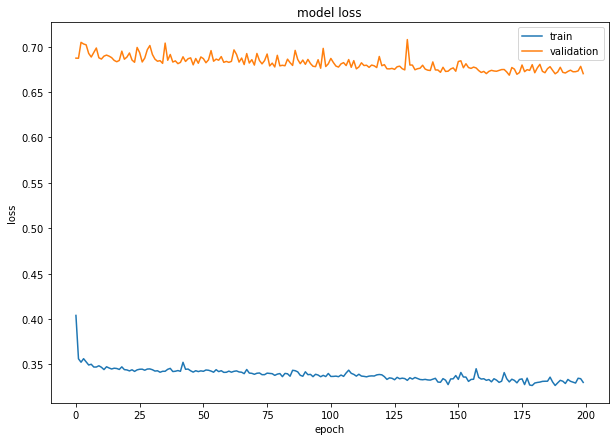

In [22]:
# Summarize history for loss
plt.figure(figsize=(10, 7))
plt.plot(training.history['loss'])
plt.plot(training.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='best')
plt.show()

### <span style="color:brown">Predicting the trend using the best DNN model</span>

In [23]:
from sklearn.metrics import accuracy_score
predict_trend = np.ones(len(X_test))
for i in range(X_test.shape[0]):
    predict_trend[i] = np.where(best_model.predict(
        np.expand_dims(X_test[i], axis=0))[0][0] > 0.5, 1, -1)
predict_trend = np.reshape(predict_trend, (1, -1)).tolist()[0]
Y_test = np.where(y_test == 0, -1, 1)

# Let us check the accuracy of the model on the test data

acc = accuracy_score(list(Y_test), list(predict_trend))

1/1 [==============================] - 0s 45ms/step


### The results might vary due to the Dropout layer and the changes in data if any.

In [24]:
print("The Accuracy of the model on the test set is:", acc*100, '%')
print("\n\n\nThe Signals Predicted\n", list(predict_trend))

The Accuracy of the model on the test set is: 56.99999999999999 %



The Signals Predicted
 [-1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, 1.0, 1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, 1.0, 1.0, -1.0, 1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0]


### <span style="color:brown">Comparing the strategy results</span>

Now, let us plot the performance of the model on the test data by multiplying the buy and sell signals with the corresponding future returns.

Once we calculate the percentage returns of the model, we will take a cumulative sum of all these returns on the test data to measure the overall performance of the model.


We have also plotted the cumulative markets returns to compare how a simple Buy and Hold strategy would have performed in comparison to our model.

The annualized interest rate in India is currently 6%. So, for the 100-day period in the test data, the interest rate would be adjusted.

### The results might vary due to the Dropout layer and the changes in data if any.

In [25]:
market_returns = pd.Series(
    data.Last.shift(-1).iloc[-test_size:].pct_change().values)
strategy_returns = pd.Series(predict_trend*market_returns)
intrest_rate = 0.06/3
Sharpe = (np.nansum(strategy_returns)-intrest_rate)/strategy_returns.std()
Sharpe

7.983612852570891

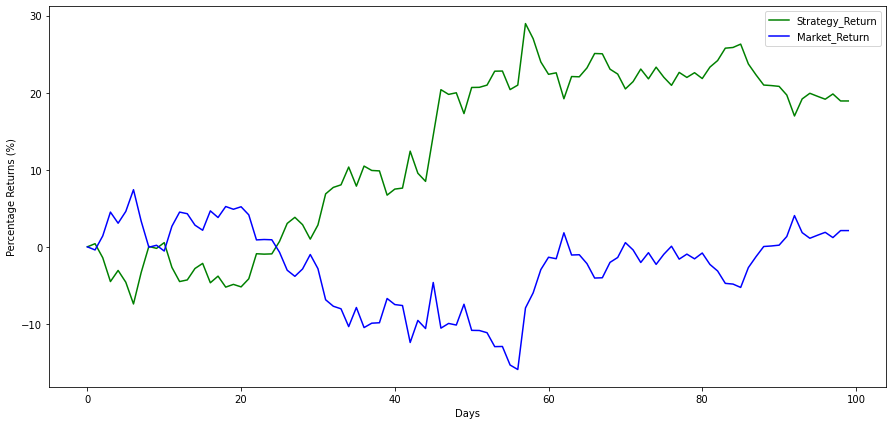

In [26]:
plt.figure(figsize=(15, 7))
plt.plot(np.nancumsum(strategy_returns)*100, c='g')
plt.plot(np.nancumsum(market_returns)*100, c='b')
plt.ylabel('Percentage Returns (%)')
plt.xlabel('Days')
plt.legend(['Strategy_Return', 'Market_Return'])
plt.show()

### <span style="color:brown">Final strategy results</span>

In the past 100 days, the model has returned (%)

In [27]:
final_return = np.nansum(strategy_returns)*100
final_return

18.917658037253027

### <span style="color:brown">Conclusion</span>

In this section, we have learnt how to use the cross-validation technique to arrive at the best possible hyperparameters for a DNN architecture. Although this process is time taking, it will save you the effort involved in manually tuning all the hyper parameters to arrive at the best possible combination. We hope you have thoroughly enjoyed this course, and look forward to seeing you soon on the Quantra portal.